# Implementations of Recommender systems:

Recommender systems are explored from the simplest through Neural Networks (NNs) and deep NN (DNN) transformer based models.

1. A nearest neighbor vector database search using rating weighted genres.
2. Linear least squares in linear or logistic regression
3. Collaborative filtering with User Id, Item Id 
4. A DNN Two-Tower Model plus a Ranking (Retrieval) Model and Re-Ranking model.  (item bias correction is also implemented)
5. An LLM Behavioral Model:
   > see https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/movielens_recommendations_transformers.ipynb#scrollTo=Rkfy65Ve09tw
6. The new [keras-rs](https://keras.io/keras_rs/) recommenders:
    * Another [sequence](https://keras.io/keras_rs/examples/sas_rec/)/behavioral model
    * TwoTower DNN that includes Ranking and Ranking metrics:
      [keras-rs Deep Recommender](https://keras.io/keras_rs/examples/deep_recommender/)
    * Training and metrics for [list-wise ranking](https://keras.io/keras_rs/examples/listwise_ranking/)


### 1. A quick look at nearest neighbor searches for similar vector embeddings:

> s : similarity measure : E x E
    takes a pair of embeddings (where E is an embedding)
    and returns a scalar measuring their similarity.

> given a query embedding q ∈ E, a recommendation system looks for an item embedding x ∈ E that is close to q, that is, has high s(q,x)

one can build a user profile out of user ratings for movies as expressed by the movie genres.  There are 18 movie genres so the multi-hot vectors will be 18 in length.

one can build an item profile out of either the L2 normalization of their genres or out of their TF-IDF scores for their genres.

- the user vector can be made for each user:
    - For each movie they rated, make a multi-hot vector of the movie genres, and multiply that multi-hot vector by the rating for that movie, then sum all of the user's multi-hot genre vectors and perform L2 normalization on it.

- the item vector can be made for each movie:
    - For each movie make a multi-hot vector for the genres it contains, then perform L2 normalization on it.

- cosine similarity can then be used to score how similar a user vector is to an item vector.  Fast search is enabled by use of a nearest neighbors or approximate nearest neighbors (ANN) vector library such as SCANN or FAISS.
    - store the movies in the ANN indexer.
    - search for the top k matches for a user in the ANN indexer, excluding those they have already seen.

- works well, but is limited in the information one can use at this point.
    - more complex vector embeddings can be made that include more information (features) for more personalization of recommendations to a user. Such embeddings need to be transformed into the same embedding space.  Multi-modal embeddings are increasingly an option.

- Collaborative Filtering and Two-Tower models learn a common embedding space for user and item embeddings (see sections 2. and 3.).

### 2. Linear Least Squares in linear or logistic regression
User to item linear least squares for each user:

coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
y_pred = X @ coefficients

where X is a matrix of rows of features for 1 user, each row having unique user_id, movie_id pairs for a rating, but the remaining features are repeat entries such as age_group.
y is the column matrix of ratings.

Pros: fast
Cons: doesn't benefit from user to user or item to item interactions.  more complex relationships are needed for additional information.

### 3. Collaborative Filtering with User Id, Item Id
   (see [colab notebook](https://colab.research.google.com/drive/1P0cTkjpURuqNs7dCJV9amK04xxRkn1zW?usp=drive_link))
    - Map user ID to a "user vector" via an embedding matrix
    - Map movie ID to a "movie vector" via an embedding matrix
    - Compute the dot product between the user vector and movie vector to obtain the similarity score between the user and the movie.
    - Train the model weights for the embeddings by comparing the estimated rating to the user's rating for the movie.  The training uses all known user-movie pairs.
    - To test the retrieval and matchings, one could use methods similar to what is used here for selecting test users, predict recommendations, and analyze with expected.
    - To test the retrieval and matchings, one could also partition the data into train and test by time for a user (80% of their time sequential ratings go in train, the rest in test).  All movie embeddings are put in the nearest neighbors database.  The top k for test users can be found in the database, excluding those they've already seen.  Does it predict any of the highly rated, and if so how likely are those...

### 4. A DNN (or NN if 1-layer) Two-Tower Model plus a Ranking (Retrieval) Model and Re-Ranking model.  (item bias correction is also implemented)

- the collaborative feature model is fast and has reasonable results.  to consider improvements in personalized recommendations, one needs a more expressive model such as a DNN and to experiment with features.
  
- The Two Tower model has:
    - a user embedding model that can include more than the user id as a feature.
    - an item embedding model that can include more than the movie id as a feature.
    - the learned embedding space contains the user and movie embeddings.

The complexity of the model, as the number of trainable parameters, should be less than the number of inputs for easier training.

For example, the movielens dataset has 1E6 user ratings of movies, 3700 unique movies, and 6000 unique users.   If we model the problem so that the label is the user's rating of a movie, the user embedding is formed from user_id of the rating, and the movie embedding is the movie_id of the rating, the number of parameters in the model is 5E5.  The number of data we have is 1E6 (the number of user ratings).  And so the problem is not under-determined.

In contrast, if we instead aggregate all of the user's movie ratings into a weighted genre vector (see section 1. above) for the user embedding and make a movie vector from its L2 normalized multi-hot genre vector, the number of model parameters is 18*(6000) and the number of data is 6000, so the problem is under-determined and ill-posed in part because of the label ratings as a multi-hot vector. 
(not to be confused with ranking models that perform list-wise calculations on features grouped by user_id...)  ... as an aside, The making of multihot features as labels is called multilabel binarization.
Under-determined systems have infinitely many solutions, and the machine learning models explore that solution space.

    * Note that an aggregation over the repeated features such as user or movie will have the same problem of having fewer inputs than trainable parameters.  A way around this could be to make subsets of the aggregation and provide new examples for each of those. 
    
        * For example, user_i has 100 movies they have rated and we want inputs to be groups of 3 of them in any order, but having the same rating.  The number of inputs then becomes C(n=100 w/ same rating, k=6) ~ 1E5 or C(n=100 w/ same rating, k=6) ~ 1E9.  This quickly becomes a very very large list of inputs for which we are essentially learning about the groupings of genres.  (An easier way to learn that relationship as implicit hidden latent weights might be through Collaborative Filtering of Two-Tower with only user id and movie id as embedding content).
        
    * Note also, that ratings grouped by user can be ordered sequentially by time and offset by some number of ratings (an n-gram approach), and formated as input to a transformer model.  see  [Keras BST example](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/movielens_recommendations_transformers.ipynb/#encode-input-features)

# The Two-Tower model
* adapted from [Tensorflow examples: Deep Recommenders](https://www.tensorflow.org/recommenders/examples/deep_recommenders) though have replaced FactorizedTopK metrics and Retrieval loss programmatically.
That Tensorflow example can be modified to insert this statement before all imports excepting os to run the code:
os.environ["TF_USE_LEGACY_KERAS"] = "1"
    * Note that meanwhile, this last month, [keras-rs](https://keras.io/keras_rs/) has been released and is compatible w/ keras-3.

* input is the query information such as a user id (or user id and seed movie id) from the user movie ratings
* the label is the user rating for the movie.
* additional features can be made for user and movie ratings biases, as shown in MMDS Netflix reference below.
e.g. μ = overall mean rating.  b_x = bias of user_x = (avg rating of user_x - μ).
b_i = bias of movie_i = (avg rating of movie_i - μ). b_x_i = μ + b_x + b_i
rating r_x_i adjusted estimate = b_x_i + sum over user x ratings (w_i_j * (r_x_j - b_x_j)).

* output is the sigmoid scaled cosine similarity score of the vector embeddings.

For the simplest model having only embeddings for user_id and movie_id, the number of trainable parameters in the model can be seen in [Keras efficient embeddings w/ MovieLens ex](https://keras.io/examples/keras_recipes/memory_efficient_embeddings)

* The number of trainable parameters is about 1.2E5 for the efficient embeddings and the number of input examples is about 1E6.  The system is over-determined and the objective is convex, so the model is trainable.

* additional features can be used to improve the results

*  find best hyper-parameters.

## Retrieval model
* input is the query information as x_query.  The query embedding q = Ψ(x_query) is created using the trained Two-Tower query model fed by a feature vector for the query(or queries).  A nearest neighbor approx algorithm can be used to find candidate embeddings that are close to q in embedding space, that is, have high similarity scores (produced by the candidate generating model above).
* output is the scores and item ids

## Scoring/Ranking model
* input is the results of the potentially many different Retrieval models.
  The candidates are pooled, sorted and the top k item ids are determined.
* The YouTube Adams et al. 2016 paper summarizes how they train their ranking models.

## Re-Ranking model
* input are the top k scored candidates.  At this stage filters can be applied like removing click-bait. Freshness, diversity, and fairness or recommendatsions are also considered.
  see [Google ML rec, DNN scoring](https://developers.google.com/machine-learning/recommendation/dnn/scoring)

### A quick look at class balance for the MovieLens ml-1m dataset: 
> unique number of movies rated = 3706

> unique number of movies total = 3883

> the number of movies not rated = 177

> unique number of users that rated = 6040

> unique number of users = 6040

The movie class imbalance is about 21 : 1 and there is no user class imbalance.

The EDA charts below show that movie genres are also imbalanced.

### Negative Sampling and Sampling Bias Corrections
The Retrieval model will preferentially find the most popular items if not corrected for item sampling bias.
There is more on this topic in [Google ML DNN training](https://developers.google.com/machine-learning/recommendation/dnn/training)
and in [a blog by Yuan Meng on negative sampling](https://www.yuan-meng.com/posts/negative_sampling/)

Below, the algorithm followed is from
"Sampling-Bias-Corrected Neural Modeling for Large Corpus Item
       Recommendations" by Yi et al. 2019
The sample bias correction calculations are added to the Two-Tower model to correct the loss estimation for each batch by using an ongoing calculation of the item sampling probability as the model evolves over epochs.  An ANN library is used in this to search for current top k predictions for each user_id in a mini-batch and then the current item probability is updated from that top k list. Note that the negative samples are taken to be the movies within the mini-batch that the user did not select.  Those contribute to the denominator of the softmax of the scores...

TODO: read more of the negative sampling and bias correction papers...

#### Great references to browse:
[MMDS Ch9, rec sys LF, incl. Netflix Prize](http://www.mmds.org/mmds/v2.1/ch09-recsys2.pdf)

[MMDS Ch9, rec sys, CF](http://www.mmds.org/mmds/v2.1/ch09-recsys1.pdf)
   
[Keras Collab Filter ex](https://keras.io/examples/#:~:text=Recommendation-,V3,Collaborative%20Filtering%20for%20Movie%20Recommendations,-V3)

[Keras DNN Transformer Based ex](https://keras.io/examples/#:~:text=for%20Movie%20Recommendations-,V3,A%20Transformer%2Dbased%20recommendation%20system,-Timeseries)

   "Deep Neural Networks for YouTube Recommendations" by Adams, Covington, Sargin 2016, 
   
   "Sampling-Bias-Corrected Neural Modeling for Large Corpus Item Recommendations" by Yi et al. 2019, 
       
    "Mixed Negative Sampling for Learning Two-tower Neural Networks in Recommendations" by Yang et al. 2020,
       
   [Google ML rec, DNN softmax](https://developers.google.com/machine-learning/recommendation/dnn/softmax)
   
   [Google ML rec, DNN scoring](https://developers.google.com/machine-learning/recommendation/dnn/scoring)
   
   [NVidia ML rec, storage and ranking](https://developer.nvidia.com/blog/offline-to-online-feature-storage-for-real-time-recommendation-systems-with-nvidia-merlin/#:~:text=Ranking%20models%20are%20a%20type%20of%20machine,interactions%2C%20such%20as%20clicks%2C%20purchases%2C%20or%20ratings)

  [Tensorflow examples: basic retrieval](https://www.tensorflow.org/recommenders/examples/basic_retrieval)
  
  [Tensorflow examples: basic ranking](https://www.tensorflow.org/recommenders/examples/basic_ranking)
  
  [Tensorflow examples: featurization](https://www.tensorflow.org/recommenders/examples/featurization)
  
  [Tensorflow examples: Deep Recommenders](https://www.tensorflow.org/recommenders/examples/deep_recommenders)

  [Tensorflow TFX tutorial](https://www.tensorflow.org/tfx/tutorials/transform/census)

[FAISS nearest neighbor search metrics](https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances)

  [ANN for Text](https://www.tensorflow.org/hub/tutorials/semantic_approximate_nearest_neighbors)

  [Keras Recommenders API](https://keras.io/keras_rs/examples/)

---
set preferred device as CPU, GPU or TPU using:
device=Device.GPU

TPU config problems (it may be that it needs tf-keras, aka keras 2):
* when I configured to use a distribution strategy, and use batch_size = 8*64 = 512 and sample_size = 10*batch_size = 5120, the 1st epoch returns loss = NaN
* when I increase the sample_size to 100xbatch_size = 51200, the 1st epoch begins but does not seem to make progress by 1.5 hours.  cannot use print statements in train_step to debug because that's not an operation in OpKernel for XLA_TPU_JIT devices.  
    * CPU and GPU configs work
* on collab, the demo code using TPU is very fast and uses batch_size=8192 and sample size = 100_000.
  
Note: do not configure for GPU or TPU if near quota.

If the chosen device is GPU or TPU and not available at session time, then an exception will be raised here.  this can be edited to let the device change to device=Device.CPU and continue

To use TPU or GPU on a dataset, the dataset must be in Google Cloud Storage or in /kaggle/input directory,
so the processing steps in this notebook were performed, then uploaded as input into the notebook and preprocessing disabled.
  
* to use Google Cloud:  ... in progress.  not implemented.
    * once the datasource exists in /kaggle/input/ or GCP:
    * enable “Google Cloud SDK” in the “Add-ons” menu of the notebook editor and add a GC SDK credentials section to the code, before the init TPU section.
    * from kaggle_secrets import UserSecretsClient
      user_secrets = UserSecretsClient()
      user_credential = user_secrets.get_gcloud_credential()
      user_secrets.set_tensorflow_credential(user_credential)
      from kaggle_datasets import KaggleDatasets
      GCS_DS_PATH = KaggleDatasets().get_gcs_path("ml-1m-preproc")

* Because the pre-processed data is now in /kaggle/input/ml-1m-preproc/, there is now a flag to skip pre-processing steps.  All of the run configuration flags are gathered here to make it easier to change:

# Config params for this app:
* device = Device.CPU or Device.TPU or Device.GPU
* run_eagerly = False
* run_preproc = False
* shuffle_data = True
* use_bias_corr = False 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
"""
Kaggle working directory: /kaggle/working/
Kaggle temp directory: /kaggle/temp/
colab working directory: /content/
    about 77GB avail to user for the current session.
    disappears afterwards.  a session is limited to 12 hrs 
    but may be terminated during high demand if not a paid
    session.
   
Kaggle TPU quota is 20 hrs per week 
Kaggle GPU quota is 30 hrs per week
Kaggle CPU has 16GB RAM, 16 cores w/ 2.3GHz, no quota, but sessions are limited to 12 hours.
Kaggle GPU have ~ 30GB RAM, 16 cores w/ 2.3GHz;
TPU 128GB of high-speed memory
Kaggle GPU weekly quota begins Central European Time (CET) on Sat (morning), so that is about 3PM on Friday for Pacific Time Zone.
"""
#python version 3.9 - 3.12, https://www.tensorflow.org/install/source
"""
on colab, the following works for TPU along with the distribution config later
!pip install -q tensorflow==2.18.0
!pip install -q tf-keras==2.18.0
import tensorflow as tf
import tf_keras as keras
    !pip install q tensorflow-tpu -f https://storage.googleapis.com/libtpu-tf-releases/index.html
but that means the models are then HDF5 format which is not ideal for use w/ keras3

in May 2025, the library versions already installed in kaggle docker img:
keras                              3.5.0
keras-core                         0.1.7
tensorflow                         2.18.0
tensorflow-datasets                4.9.7

"""
import enum
class Device(enum.Enum):
    CPU = "CPU"
    GPU = "GPU"
    TPU = "TPU"

#change this manually as needed:  for training on Kaggle, if have enough quota: use CPU or GPU
device = Device.CPU

#do not set to true if using TPU or GPU
run_preproc = False

#tensorflow 2.19.0 and keras 3.9.2 are stable releases, but the platform libraries such as pandas
# expect tf 2.18.0
#!pip install -q tensorflow==2.18.0
!pip install -q tensorflow[and-cuda]==2.18.0
!pip install -q keras==3.9.2

if device == Device.TPU:
    if run_preproc:
        raise Exception("set run_preproc=False when device = Device.GPU")
    # see https://www.tensorflow.org/install/pip
    #https://www.tensorflow.org/install/gpu_plugins   ???
    #!pip install tensorflow-gpu==2.19.0
    #!pip install -q tensorflow[and-cuda]==2.18.0
elif device == Device.TPU:
    if run_preproc:
        raise Exception("set run_preproc=False when device = Device.TPU")
    !pip install q tensorflow-tpu -f https://storage.googleapis.com/libtpu-tf-releases/index.html

import tensorflow as tf
import keras

import os
import sys

# can choose jax, pytorch or tensorflow for KERAS_BACKEND, though many layers in the keras
# pre-processing pipeline require tensorflow
os.environ["KERAS_BACKEND"] = "tensorflow"  
from keras import layers, ops

device_physical = ""

print(f"\nphysical devices = {tf.config.list_physical_devices()}\n")

if device == Device.GPU:
    if tf.config.list_physical_devices('GPU'):
        device_physical = tf.config.list_physical_devices('GPU')[0]
        tf.config.set_visible_devices(device_physical, 'GPU')
        print("GPU is available and set as default device.")
        # or do I need to set where needed: with tf.device("/gpu:0")
    else:
        print("GPU is not available")
        raise Exception("GPU not avail")
        #device = Device.CPU
elif device == Device.TPU:
    if tf.config.list_physical_devices('TPU'):
        device_physical = tf.config.list_physical_devices('TPU')[0]
        tf.config.set_visible_devices(device_physical, 'TPU')
        print("TPU is available and set as default device.")
    else:
        print("TPU is not available")
        raise Exception("TPU not avail")
        #device = Device.CPU
else:
    tf.config.list_physical_devices()

print(f"device={device}\n")

#run_eagerly = False lets keras build a computation graph to run the model more efficiently.   
# when run_eagerly is False, Tensorflow tensors are Symbolic and so their information is not available.
# run_eagerly is often set to True when one wants access to Tensor contents for debugging.
run_eagerly = False

import enum
class TrainState(enum.Enum):
    DEBUG = "DEBUG"
    HYPER_TUNE_PARAMS = "HYPER_TUNE_PARAMS"
    FIX_PARAMS = "FIX_PARAMS"
    
#set train_state = HYPER_TUNE_PARAMS when training on TPU, CPU.
#set train_state = FIX_PARAMS to load the best trained model
train_state : TrainState = TrainState.DEBUG

## shuffle_data = True should be used for training.  one can set it to False to enable the model save, load, tests that predictions are same
shuffle_data = True

import datetime
from typing import Union

import shutil
import pytz
PST = pytz.timezone("US/Pacific")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#import inspect

#use 32 bit for TPU compatability
policy = keras.mixed_precision.Policy('float32')
keras.mixed_precision.set_global_policy(policy)

print(f'Tensorflow Version: {tf.__version__}')
print(f'Keras Version: {keras.__version__}')
print(f'Python Version: {sys.version}')
print(f'device: {device}')

#set to True to follow Yi et al. item bias correction for loss.
# WARNING: haven't yet tested my implementation of the bias correction
use_bias_corr = False

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.6/217.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine ==

2025-05-23 04:17:11.239562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747973831.554332      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747973831.637144      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



physical devices = [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

device=Device.CPU

Tensorflow Version: 2.18.0
Keras Version: 3.9.2
Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
device: Device.CPU
2025-05-22T21:17:32.009016-07:00


2025-05-23 04:17:31.964075: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
import os
#ml-1m-preproc/
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("done")

/kaggle/input/ml-1m-preproc/users.csv
/kaggle/input/ml-1m-preproc/movie_candidates.csv
/kaggle/input/ml-1m-preproc/ratings_test.csv
/kaggle/input/ml-1m-preproc/ratings_val.csv
/kaggle/input/ml-1m-preproc/ratings_train.csv
done


Download movielens dataset if not already downloaded.

In [3]:
kaggle_proj = 'ml-1m'
working_dir = '/kaggle/working/'
inp_proj_dir = os.path.join('/kaggle/input/', 'ml-1m-preproc')

base_dir = os.environ.get('PWD')
if not working_dir.startswith(base_dir):
    #colab path:
    if base_dir.startswith("/content"):
        working_dir = "/content/"
        #TODO: edit for input_proj_dir as needed
    else:
        #laptop path:
        if not base_dir.endswith('recommendation_system'):
            base_dir += '/recommendation_system'
        working_dir = base_dir + '/data/'
        inp_proj_dir = os.path.join(working_dir, kaggle_proj)

proj_dir = working_dir + kaggle_proj + '/'
models_dir = working_dir + 'models/'
if not inp_proj_dir.endswith('/'):
    inp_proj_dir += '/'
    
#print(f'base_dir={base_dir}\n')
#print(f'proj_dir={proj_dir}\n')
#print(f'proj_dir exists={os.path.exists(proj_dir)}\n')

if not os.path.exists(proj_dir):
    from urllib.request import urlretrieve
    from zipfile import ZipFile
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", \
                filename=working_dir +"movielens.zip")
    os.mkdir(proj_dir)
    ZipFile(file=working_dir + "movielens.zip", mode="r").extractall(path=working_dir)
    # tensorflow delimeter is single character, so change delimeter :: to \t
    for file in ['movies.dat', 'users.dat', 'ratings.dat']:
        _fln = proj_dir + file
        _fln2 = proj_dir + 'tmp'
        command = "LC_ALL=UTF8 sed 's/::/\t/g' " + _fln + " > " + _fln2
        os.system(command)
        shutil.copy(_fln2, _fln)
    
    ## sort the ratings file by unix timestamp to make the loading easier for train, dev, test splits.
    ## this is convenient for the loading before pre-processing, but could be perfomed
    ## in memory using pandas instead.
    #_fln = proj_dir + "ratings.dat"
    #_fln2 = proj_dir + "ratings_sorted.dat"
    #command = "cat " + _fln + " | sort -n -t $'\t' -k 4 > " + _fln2
    #os.system(command)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(proj_dir):
#for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import platform
import subprocess
# get the number of lines from each file. this is for the non-pandas pre-processing pipeline
# but is convenient to leave here for pandas pre-processing too.
_tmp = subprocess.run(['wc', '-l', proj_dir + 'ratings.dat'], stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
print(_tmp)
num_ratings = int(_tmp.split(" ")[0])

_tmp = subprocess.run(['wc', '-l', proj_dir + 'movies.dat'], stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
num_movie_lines = int(_tmp.split(" ")[0])

_tmp = subprocess.run(['wc', '-l', proj_dir + 'users.dat'], stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
num_user_lines = int(_tmp.split(" ")[0])

print(f'num_ratings={num_ratings}, num_movie_lines={num_movie_lines}, num_user_lines={num_user_lines}\n')
   
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/ml-1m/users.dat
/kaggle/working/ml-1m/ratings.dat
/kaggle/working/ml-1m/README
/kaggle/working/ml-1m/tmp
/kaggle/working/ml-1m/movies.dat
1000209 /kaggle/working/ml-1m/ratings.dat
num_ratings=1000209, num_movie_lines=3883, num_user_lines=6040

2025-05-22T21:17:34.571338-07:00


In [4]:
#shutil.rmtree(proj_dir)

#to rewrite of intermediate csv files, delete this so that a check for them fails in a later section:
if False:
    for filename in os.listdir(proj_dir):
        if filename.endswith('.csv'):
            file_path = os.path.join(proj_dir, filename)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except OSError as e:
                print(f"Error deleting {file_path}: {e}")
if False:
    for filename in os.listdir(proj_dir):
        if filename.startswith('ratings_'):
            file_path = os.path.join(proj_dir, filename)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except OSError as e:
                print(f"Error deleting {file_path}: {e}")


print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())


2025-05-22T21:17:34.641759-07:00


### Set flags to run the models and their pre-processing steps:

# Data Preprocessing and Transformations

Software like Databricks, Apache Spark, and cloud data pipelines offered by Google, AWS, Azure, Meta, etc. could be used. consider TFX too.  
consider adapting to use [FeatureSpace](https://keras.io/examples/structured_data/feature_space_advanced/).

Making the process more parallelizable would speed up the training...
For large datasets, one would prefer to use batch processing when loading the data and pre-processing the data, and continue with mini-batching within the model fitting.

Because the ratings tensorflow datasets need columns from users.dat (gather operations), will perform the pre-processing steps before loading into tensorflow datasets.

Note that operations on the tensorflow dataset that are customized within the model should be composed of standard tensorflow or keras operations unless one is willing to write their own __gradient__ calculations.

__Data Pre-Processing with Pandas, Tensorflow, Keras

https://keras.io/api/layers/preprocessing_layers/
https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html
https://www.tensorflow.org/guide/keras/preprocessing_layers
https://pandas.pydata.org/docs/user_guide/index.html
Keras Code Examples can be explored for pre-processing.

Float32 and int32 are used throughout code so that it can run on TPUs.


In [5]:
genres = ["Action", "Adventure", "Animation", "Children", "Comedy", "Crime"]
genres += ["Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical"]
genres += ["Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
# for tensorflow pre-processing, use keras.layers.StringLookup: turns
genres_to_idx_dict = {v:i for i, v in enumerate(genres)}

age_groups = [1, 18, 25, 35, 45, 50, 56]
age_groups_to_idx_dict = {v:i for i, v in enumerate(age_groups)}

genders = ['F', 'M']
genders_to_idx_dict = {'F':0, 'M':1}

# they're already in their categorical value
#occupations = ["other", "academic/educator", "artist", "clerical/admin", "college/grad student", \
#	"customer service", "doctor/health care", "executive/managerial", "farmer", "homemaker", \
#	"K-12 student", "lawyer", "programmer", "retired", "sales/marketing", \
#	"scientist", "self-employed", "technician/engineer", "tradesman/craftsman", "unemployed", \
#	"writer"]
#occupations_to_idx_dict = {v:i for i, v in enumerate(occupations)}
_mh = [0 for i in range(len(genres))]
_mi = [0 for i in range(len(age_groups))]
_mj = [0 for i in range(len(genders))]
_mk = [0 for i in range(21)]

# write the train, test, val partition where partition is by time and percentage of user ratings

n_val = int(0.05*num_ratings)
n_test = n_val
n_train = num_ratings - (n_val + n_test)
print(f'compare train, val, test sizes w/o user_id time ordering = {n_train, n_val, n_test}\n')

if os.path.exists(proj_dir + "ratings_test.dat"):
    nums = []
    for fl in ['ratings_train.dat', 'ratings_val.dat', 'ratings_test.dat']:
        _tmp = subprocess.run(['wc', '-l', proj_dir + fl], stdout=subprocess.PIPE).stdout.decode('utf-8').strip()
        print(_tmp)
        nums.append(int(_tmp.split(" ")[0]))
    n_train, n_val, n_test = nums[0], nums[1], nums[2]
elif run_preproc:
    from sklearn.model_selection import train_test_split
    ratings = pd.read_csv( \
        proj_dir + "ratings.dat", \
        sep="\t", \
        names=["user_id", "movie_id", "rating", "timestamp"], \
        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.float32, 'timestamp': np.int32}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    # a quick check that the (user_id, movie_id) ratings are unique:
    n_pairs = ratings.groupby(['user_id', 'movie_id']).ngroups
    n_user_ratings = ratings['user_id'].count()
    print(f'n_user_ratings={n_user_ratings}, n_pairs of unique(user_id, movie_id)={n_pairs}\n')
    
    #ratings = ratings.sort_values(by=['user_id', 'timestamp'])
    # for each user we want to partition their data by time to put 80% into train and 20% into test
    user_ts_dict = ratings.groupby(['user_id'])['timestamp'].quantile(0.8).to_dict()
    train_rows = []
    test_rows = []
    for index, row in ratings.iterrows():
        threshold = user_ts_dict[row['user_id']]
        if row['timestamp'] > threshold:
            test_rows.append(index)
        else:
            train_rows.append(index)
    ratings_train = ratings.loc[train_rows]
    ratings_test = ratings.loc[test_rows]
    #TODO: consider using argument stratification=timestamp 
    ratings_val, ratings_test = train_test_split(ratings_test, test_size=0.5, shuffle=True)
    n_train = ratings_train['user_id'].count()
    n_val = ratings_val['user_id'].count()
    n_test = ratings_test['user_id'].count()
    # persist to files in same format as ratings.dat.  features use sep='|',
    ratings_train.to_csv(proj_dir + "ratings_train.dat", index=False, sep="\t", header=False)
    ratings_val.to_csv(proj_dir + "ratings_val.dat", index=False, sep="\t", header=False)
    ratings_test.to_csv(proj_dir + "ratings_test.dat", index=False, sep="\t", header=False)

print(f'train, val, test sizes = {n_train, n_val, n_test}\n')
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

compare train, val, test sizes w/o user_id time ordering = (900189, 50010, 50010)

train, val, test sizes = (900189, 50010, 50010)

2025-05-22T21:17:34.836685-07:00


In [6]:
!pip install -q zipcodes
from collections import defaultdict, OrderedDict
import zipcodes

def transform_genres(dataframe):
    print(f'transform_genres\n')
    def _map_fn_sparse(entry):
        tmp = entry.replace("Children's", "Children")
        return list(map(lambda x: genres_to_idx_dict.get(x), tmp.split("|")))
    dataframe['genres'] = dataframe['genres'].apply(_map_fn_sparse)
    return dataframe

def transform_col_to_onehot(dataframe, col_name, col_dict=None):
    print(f'transform_col_to_onehot {col_name}\n')
    def _map_fn(entry):
        if col_name == 'age_group':
            _vec = _mi.copy()
        elif col_name == 'gender':
            _vec = _mj.copy()
        elif col_name == 'occupation':
            _vec = _mk.copy()
        if not col_dict:
            _vec[entry] = 1
        else:
            _vec[col_dict[entry]] = 1        
        return _vec
    dataframe[col_name] = dataframe[col_name].apply(_map_fn)
    return dataframe

def ins_tz(users_df):
    ''' calculates timezone from zip_code'''
    def _map_fn(zc):
        try:
            zip_data = zipcodes.matching(zc)
            timezone_str = zip_data[0]['timezone']
            timezone = pytz.timezone(timezone_str)
            return timezone.zone
        except Exception as ex:
            print(f"Error for zipcode {zc}")
            #use a default of kansas as us geographic center, which is Central 
            return 'America/Chicago'
    users_df['timezone'] = users_df['zip_code'].apply(_map_fn)
    return users_df

def calc_hr_bin(tz : str, ts : np.int32) -> np.int32:
    '''
    Args:
       tz : timezone string
       ts : timestamp
    '''
    utc_time = datetime.datetime.fromtimestamp(ts, tz=pytz.utc)
    timezone = pytz.timezone(tz)
    local_time = utc_time.astimezone(timezone)
    hr = int(np.round(local_time.hour + (local_time.minute/60.)))
    return np.max([0, (hr-1)//3])
    
def ins_hr_category(dataframe):
    '''to ratings, add 'hr_bin' as a numerical index for the local hour of the rating 
    where the hour is in a 24 hour clock and hr_bin is the index of the hour in one of 8 ordered bins.
    '''        
    dataframe['hr_bin'] = dataframe.apply(lambda row: calc_hr_bin(row['timezone'], row['timestamp']), axis=1)
        
def encode_list_as_string(int_list : list, separator=","):
    return separator.join(map(str, int_list))

def encode_np_array_as_string_sep_comma(input : np.ndarray, separator=","):
    return separator.join(input.astype(str))

def sum_vectors(series):
    return np.sum(np.stack(series.values), axis=0).tolist()

'''
Other features to consider adding:

geohashing for location transformation of lat, lng

number of ratings the user has made.

number of ratings the user has made up to that point (though this suggests should use
a sequence model like the multi-head attention layer instead and format the data for that)

tf-idf for the rated movie genres.  It gives information about the rareness of a genres.

tf-idf for the rated movie genres weighted by ratings (specific to the train, val, test partition dataset)
'''

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 19.8 MB/s eta 0:00:00
2025-05-22T21:17:40.445914-07:00


In [7]:
# pre-processing for the ratings model that is not aggregated data
if run_preproc and not os.path.exists(proj_dir + 'ratings_test.csv'):
    
    movies = pd.read_csv( \
        proj_dir + "movie_candidates.csv", \
        sep="|", \
        names=["movie_id", "genres"], \
        dtype={'movie_id': np.int32, 'genres': object}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )

    users = pd.read_csv( \
        proj_dir + "users.dat", \
        sep="\t", \
        names=["user_id", "gender", "age_group", "occupation", "zip_code"], \
        dtype={'user_id': np.int32, 'gender':str, 'age_group': np.int32, \
            'occupation': np.int32, 'zip_code': str}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    print(f'users: num missing values\n{users.isnull().sum()}\n')

    #Numerical features such as age group should be presented simply as normalized values or replaced by binned indexes (== ordinal variables).  
    users['age_group'] = users['age_group'].apply(lambda x: age_groups_to_idx_dict[x])
    
    #Gender is a categorical variable and is stored sparsely here
    users['gender'] = users['gender'].replace({'F': '0', 'M': '1'})
    users['gender'] = users['gender'].astype('int')

    #calc 'timezone'
    users = ins_tz(users)
    #print(f'users.csv columns: {users.columns}\n')
    #print(f'users {users.head()}\n')
    
    ratings_train = pd.read_csv( \
        proj_dir + "ratings_train.dat", \
        sep="\t", \
        names=["user_id", "movie_id", "rating", "timestamp"], \
        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating':np.float32, 'timestamp': np.int32}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    ratings_val = pd.read_csv( \
        proj_dir + "ratings_val.dat", \
        sep="\t", \
        names=["user_id", "movie_id", "rating", "timestamp"], \
        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.float32, 'timestamp': np.int32}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    ratings_test = pd.read_csv( \
        proj_dir + "ratings_test.dat", \
        sep="\t", \
        names=["user_id", "movie_id", "rating", "timestamp"], \
        dtype={'user_id': np.int32, 'movie_id': np.int32, 'rating': np.float32, 'timestamp': np.int32}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    
    ratings_train = ratings_train.merge(users, on='user_id', how='left')
    ratings_val = ratings_val.merge(users, on='user_id', how='left')
    ratings_test = ratings_test.merge(users, on='user_id', how='left')
    ratings_train = ratings_train.drop('zip_code', axis=1)
    ratings_val = ratings_val.drop('zip_code', axis=1)
    ratings_test = ratings_test.drop('zip_code', axis=1)

    #print(f'ratings_train {ratings_train.head()}\n')
    
    # hr_bin is a categorical variable and is stored sparsely here, and then the model transforms it
    # into a one-hot vector.
    # can use it as is, or if a smaller embedding than 18 is wanted, it can be input to an embedding layer.
    for df in [ratings_train, ratings_val, ratings_test]:
        ins_hr_category(df)
        df['rating'] /= 5.0

    users.to_csv(proj_dir + "users.csv", index=False, sep="|", header=False)

    #add sparse genres to ratings
    _dict = movies.to_dict('records')
    movie_id_genres_dict = {ele['movie_id'] : ele['genres'] for ele in _dict}
    for df in [ratings_train, ratings_val, ratings_test]:
        df['genres'] = df['movie_id'].apply(lambda x: movie_id_genres_dict[x])
    ratings_train.to_csv(proj_dir + "ratings_train.csv", index=False, sep="|", header=True)
    ratings_val.to_csv(proj_dir + "ratings_val.csv", index=False, sep="|", header=True)
    ratings_test.to_csv(proj_dir + "ratings_test.csv", index=False, sep="|", header=True)

    print(f'users.csv columns: {users.columns}\n')
    print(f'    dtypes: {users.dtypes}\n')
    print(f'ratings_*.csv columns: {ratings_train.columns}\n')
    print(f'    dtypes: {ratings_train.dtypes}\n')

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-22T21:17:40.535999-07:00


In [8]:
if run_preproc and not os.path.exists(proj_dir + "movie_candidates.csv"):

    movies = pd.read_csv( \
        proj_dir + "movies.dat", \
        sep="\t", \
        names=["movie_id", "title", "genres"], \
        dtype={'movie_id': np.int32, 'title': str, 'genres': str}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    movies = movies.drop('title', axis=1)
    print(f'movies: num missing values\n{movies.isnull().sum()}\n')

    movies = transform_genres(movies)
    
    movies['genres'] = movies['genres'].apply(lambda x: encode_list_as_string(x))
    movies = movies.sort_values(by='movie_id')
    print(f'movies.head()=\n{movies.head()}\n')

    print(f'\nmovies.columns={movies.columns}\n')
    print(f'\nmovies.dtypes={movies.dtypes}\n')
    
    movies.to_csv(proj_dir + "movie_candidates.csv", index=False, sep="|", header=False)

    print(f'wrote file movie_candidates.csv\n')

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-22T21:17:40.610520-07:00


# EDA of features

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


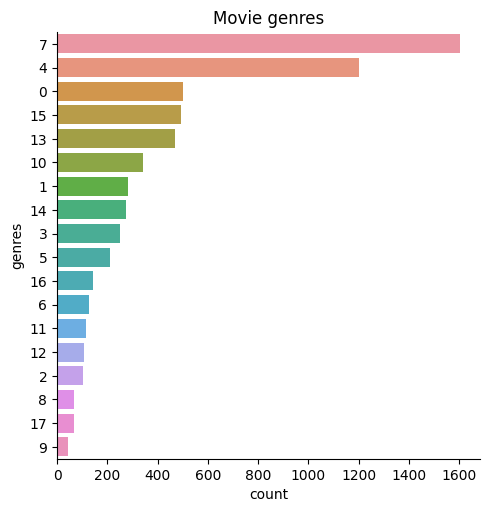

7 : Drama

4 : Comedy

0 : Action

15 : Thriller

13 : Romance

10 : Horror

1 : Adventure

14 : Sci-Fi

3 : Children

5 : Crime

16 : War

6 : Documentary

11 : Musical

12 : Mystery

2 : Animation

8 : Fantasy

17 : Western

9 : Film-Noir



/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


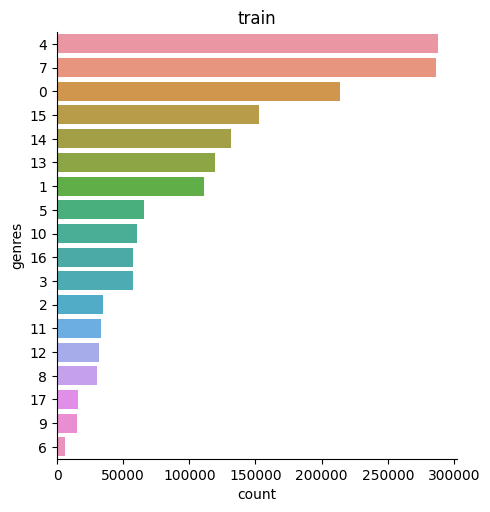

4 : Comedy

7 : Drama

0 : Action

15 : Thriller

14 : Sci-Fi

13 : Romance

1 : Adventure

5 : Crime

10 : Horror

16 : War

3 : Children

2 : Animation

11 : Musical

12 : Mystery

8 : Fantasy

17 : Western

9 : Film-Noir

6 : Documentary



/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


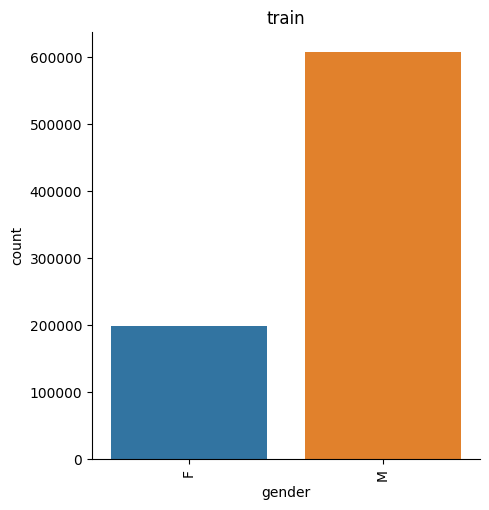

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


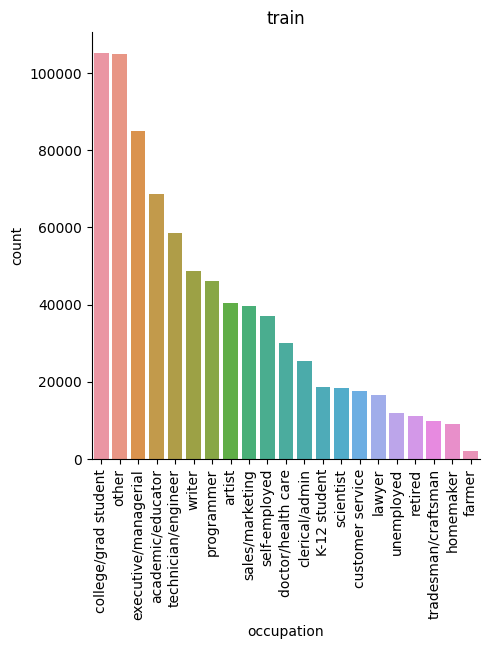

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


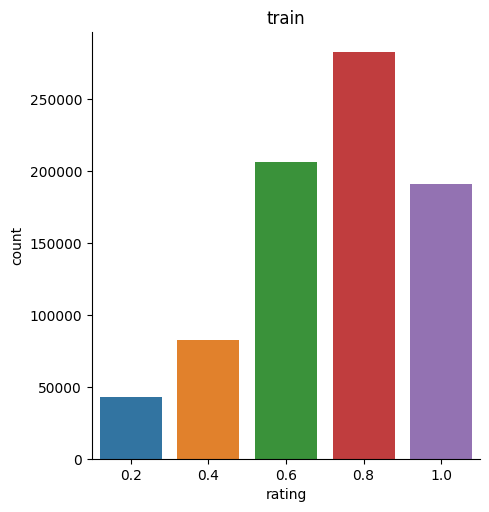

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


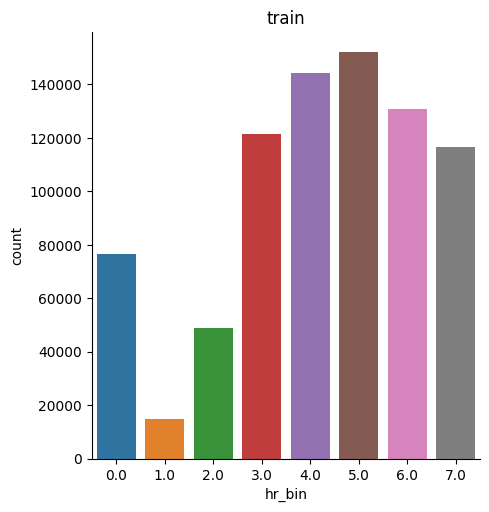

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


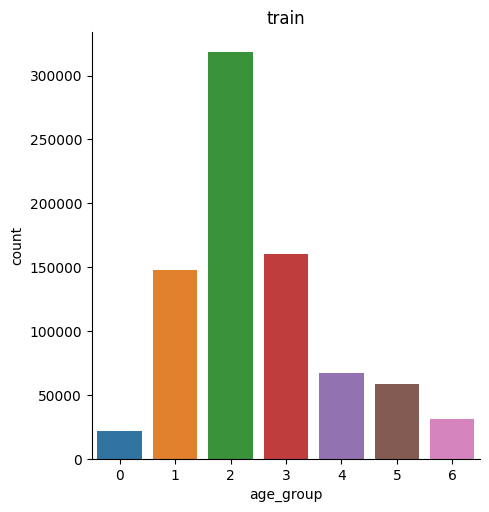

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


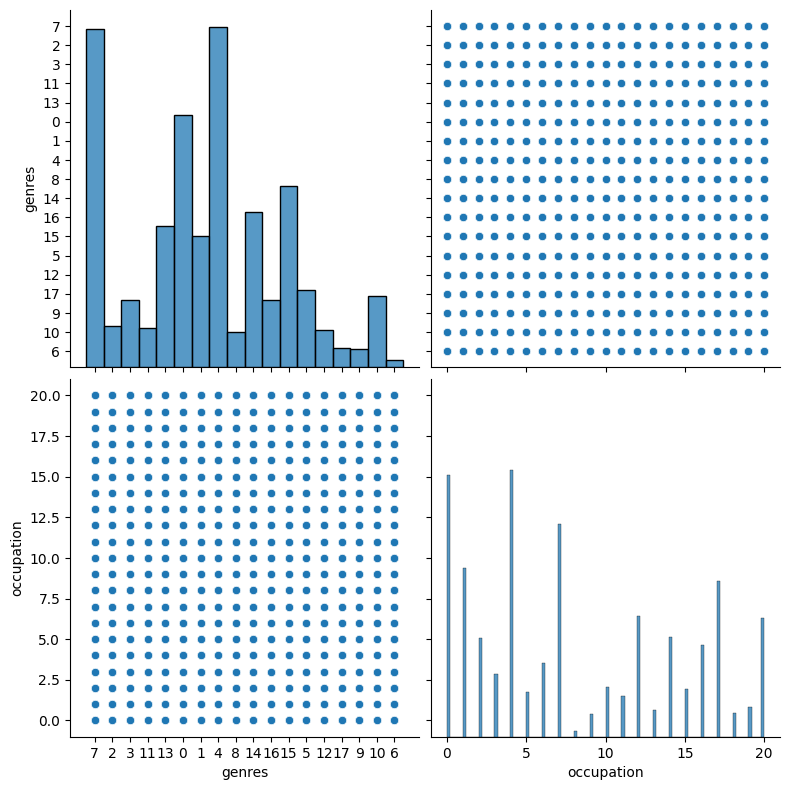

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

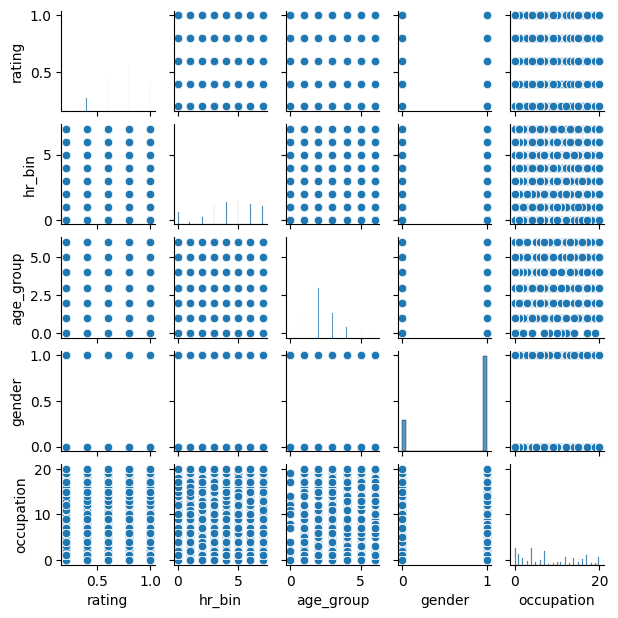

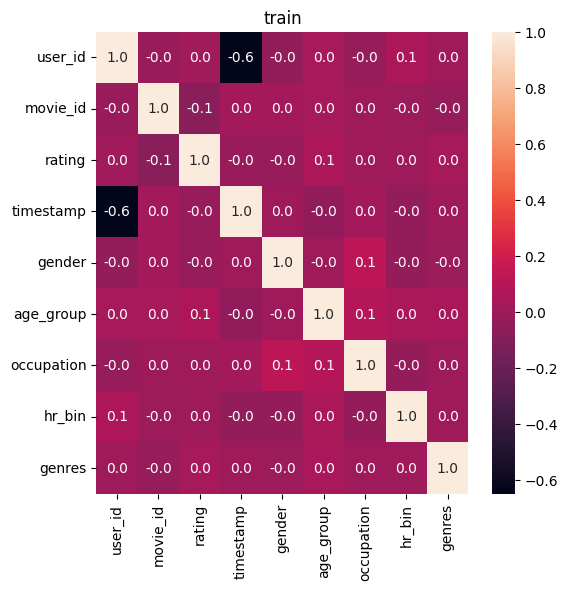

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


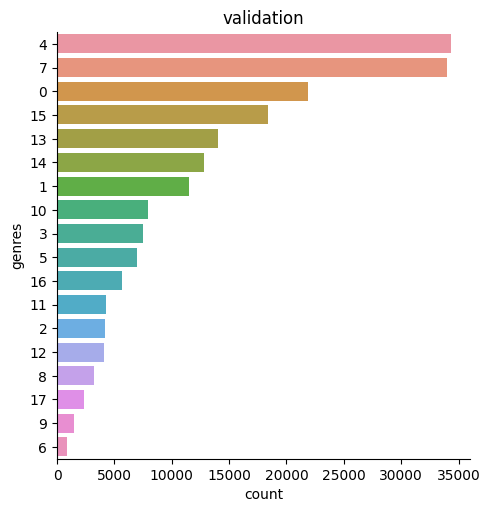

4 : Comedy

7 : Drama

0 : Action

15 : Thriller

13 : Romance

14 : Sci-Fi

1 : Adventure

10 : Horror

3 : Children

5 : Crime

16 : War

11 : Musical

2 : Animation

12 : Mystery

8 : Fantasy

17 : Western

9 : Film-Noir

6 : Documentary



/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


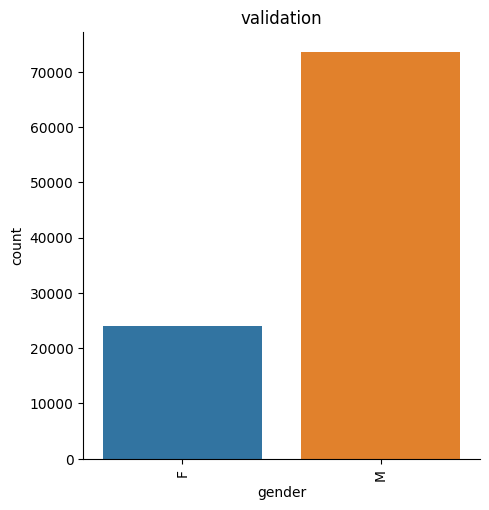

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


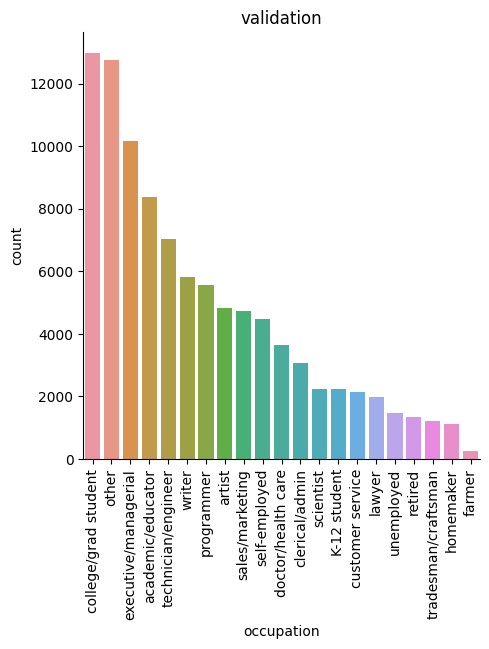

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


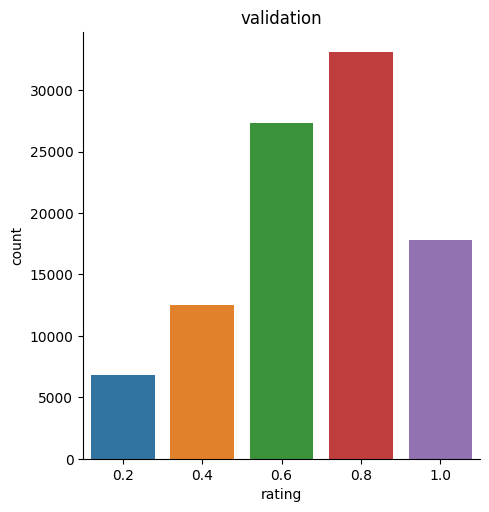

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


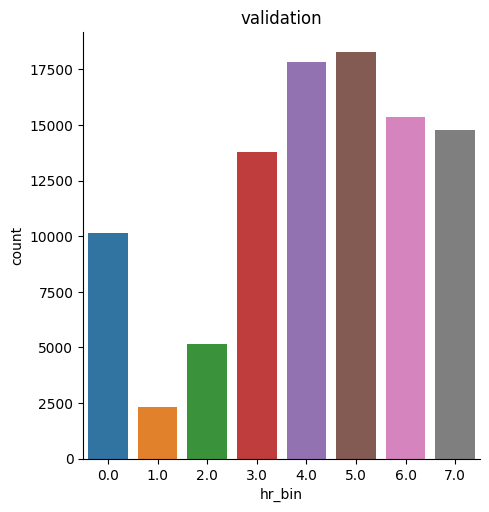

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


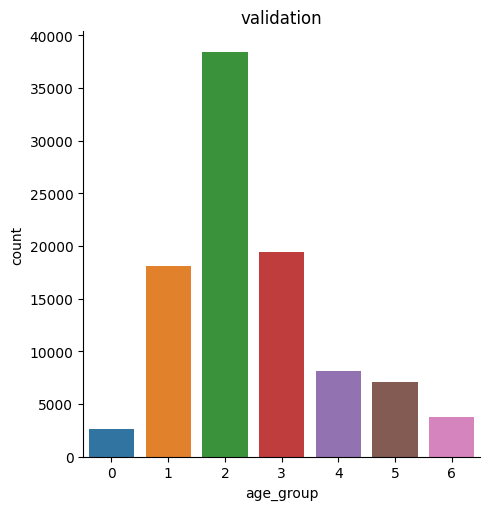

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


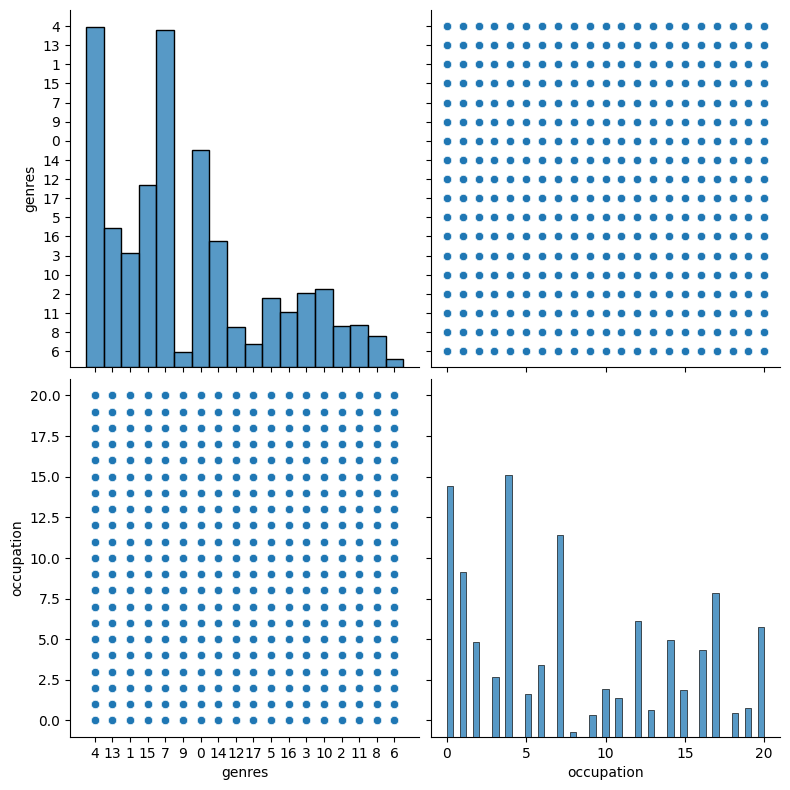

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

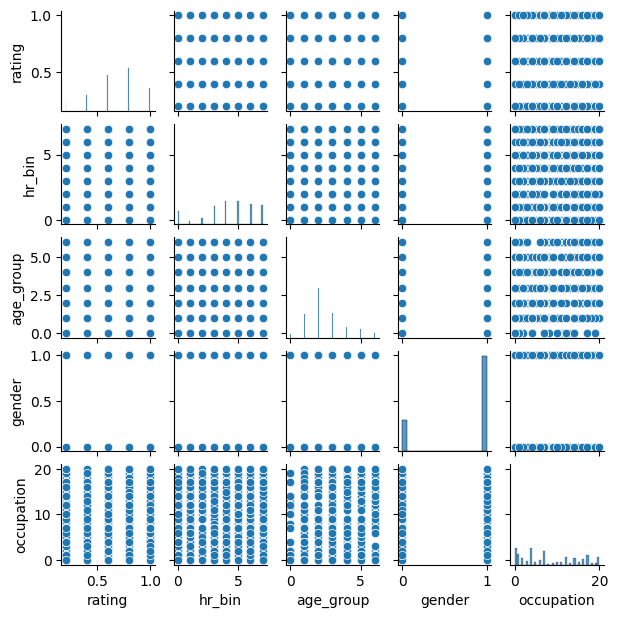

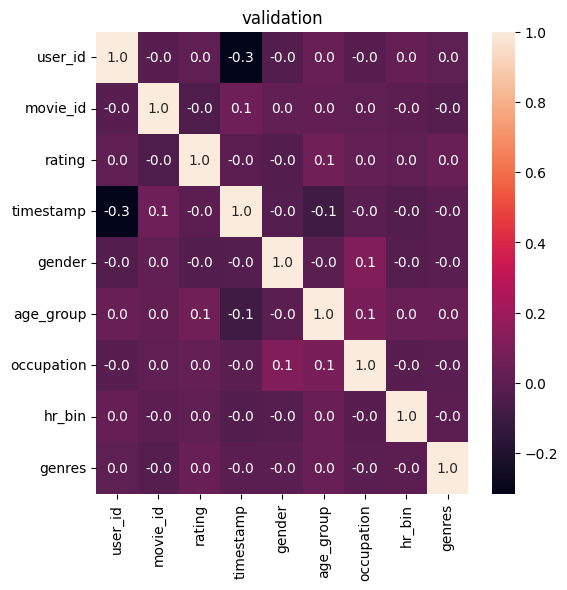

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


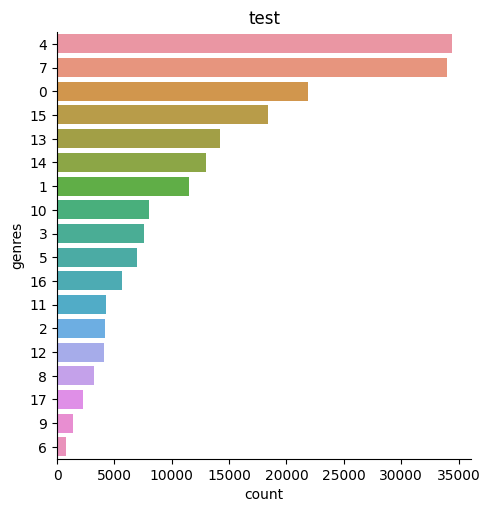

4 : Comedy

7 : Drama

0 : Action

15 : Thriller

13 : Romance

14 : Sci-Fi

1 : Adventure

10 : Horror

3 : Children

5 : Crime

16 : War

11 : Musical

2 : Animation

12 : Mystery

8 : Fantasy

17 : Western

9 : Film-Noir

6 : Documentary



/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


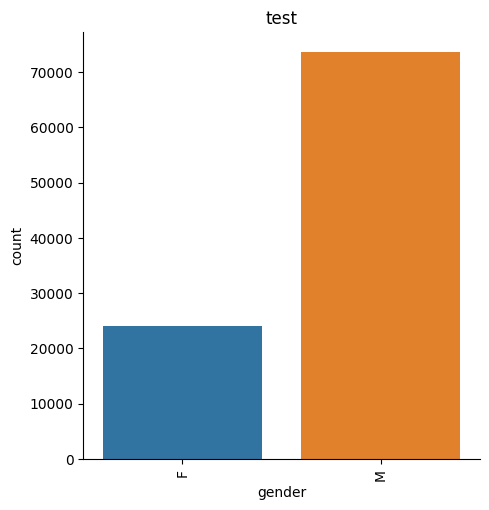

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


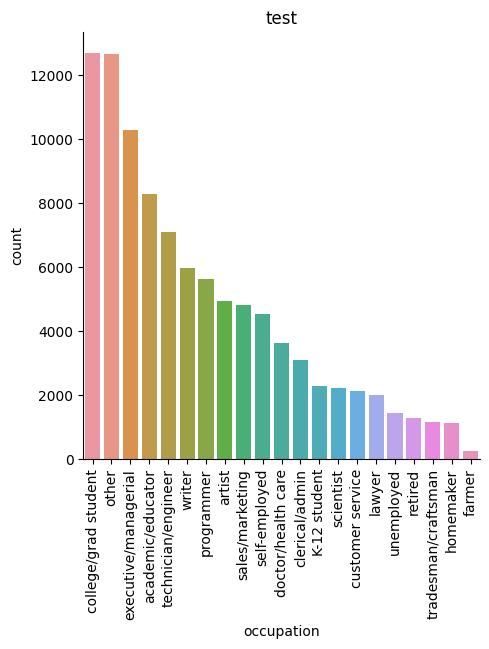

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


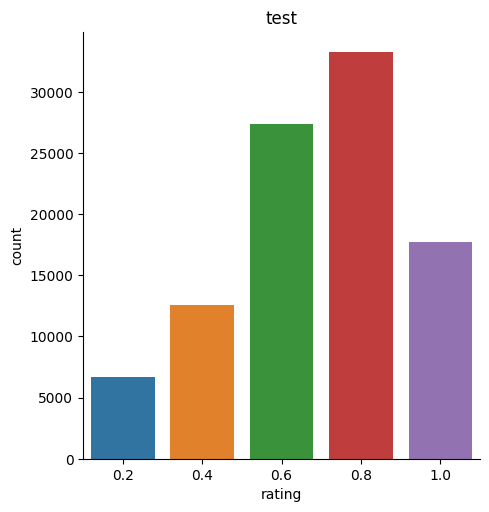

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


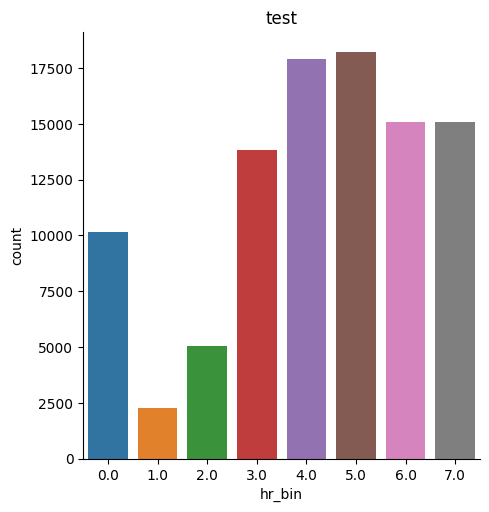

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


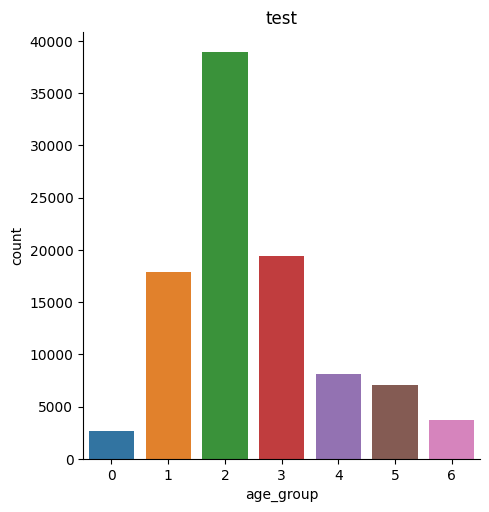

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


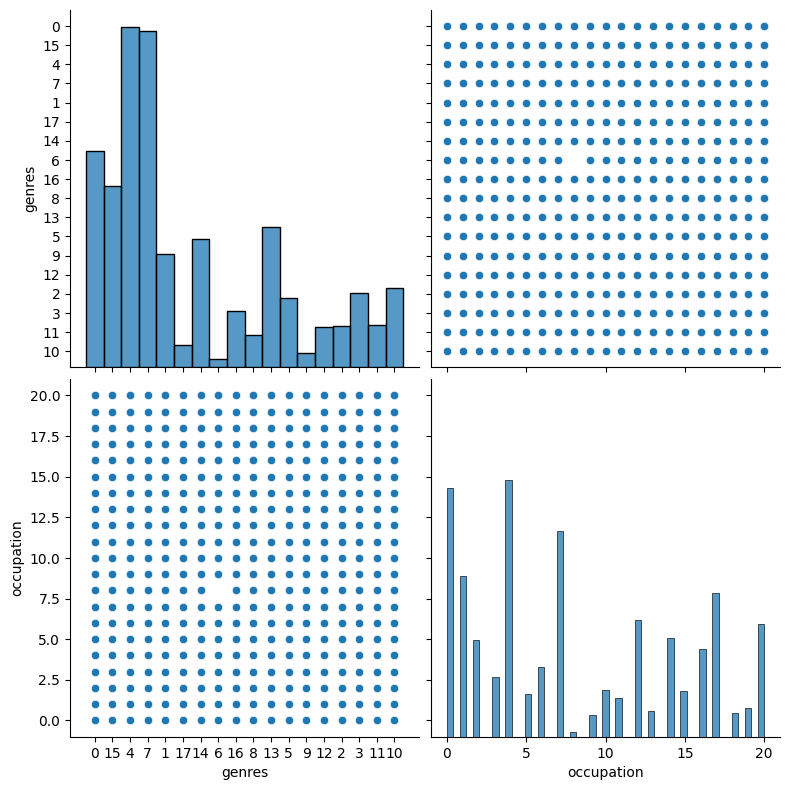

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

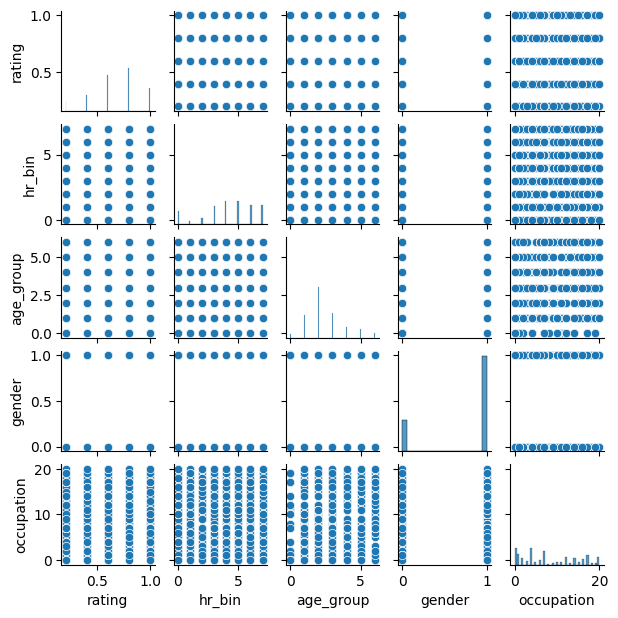

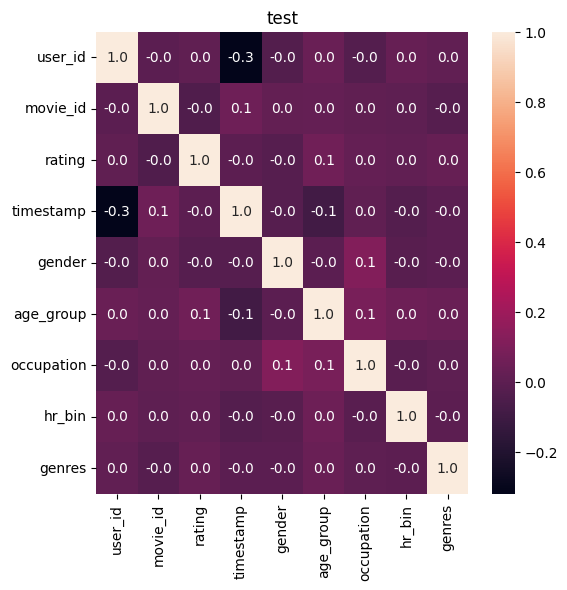

2025-05-22T21:19:26.443438-07:00


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
     
def plot_features():
    movies = pd.read_csv( \
        os.path.join(inp_proj_dir, "movie_candidates.csv"), \
        sep="|", \
        names=["movie_id", "genres"], \
        dtype={'movie_id': np.int32, 'genres': object}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    # for each category, aggregate the movie ids
    movies['genres'] = movies['genres'].str.split(',')
    movie_genres = movies.explode('genres')
    ordered = movie_genres['genres'].value_counts().index
    sns.catplot(data=movie_genres, y="genres",  kind="count", order=ordered).set(title='Movie genres')
    plt.show()
    for i in ordered:
        print(f"{i} : {genres[int(i)]}\n")

    labels_dict = {}
    labels_dict['rating'] = {1.0: '5', 0.8:'4', 0.6:'3', 0.4:'2', 0.2:'1', 0.:'0'}
    labels_dict['hr_bin'] = {0:'1-3', 1:'4-6', 2:'7-9', 3:'10-12', 4:'13-15', 5:'16-18', 6:'19-21', 7:'22-24'}
    labels_dict['age_group'] = {0:'1', 1:'18', 2:'25', 3:'35', 4:'45', 5:'50', 6:'56'}
    labels_dict['gender'] = {0:'F', 1:'M'}
    labels_dict['occupation'] = {0:  "other", 1:  "academic/educator", 2:  "artist", 3:  "clerical/admin", 4:  "college/grad student", 5:  "customer service", \
        6:  "doctor/health care", 7:  "executive/managerial", 8:  "farmer", 9:  "homemaker", 10:  "K-12 student", 11:  "lawyer", 12:  "programmer", \
        13:  "retired", 14:  "sales/marketing", 15:  "scientist", 16:  "self-employed", 17:  "technician/engineer", 18:  "tradesman/craftsman", \
        19:  "unemployed", 20:  "writer"}

    labels_dict_arrays = {}
    for k in labels_dict:
        labels_dict_arrays[k]=[labels_dict[k][k2] for k2 in labels_dict[k]]

    num_cols = ['rating', 'hr_bin', 'age_group']
    cat_cols = ['gender', 'occupation']
    all_cols = num_cols + cat_cols

    def plot_ratings(filename: str, label:str):
        data = pd.read_csv( \
            os.path.join(inp_proj_dir, filename), header = 0, \
            sep="|", \
            names=['user_id', 'movie_id', 'rating', 'timestamp',\
                'gender', 'age_group', 'occupation', 'timezone', 'hr_bin', 'genres'], \
            dtype={'user_id':np.int32, 'movie_id': np.int32, 'rating' : np.float32, \
                'timestamp':np.int32, 'hr_bin':np.float32, 'gender':np.int32, \
                'age_group' : np.int32, 'occupation':np.int32, 'timezone':str, 'genres':str},\
            encoding="ISO-8859-1", \
            engine="python", \
        )

        data = data.drop('timezone', axis=1)
    
        data['genres'] = data['genres'].str.split(',')
        data_genres = data.explode('genres')
        ordered_2 = data_genres['genres'].value_counts().index
        sns.catplot(data=data_genres, y="genres",  kind="count", order=ordered_2).set(title=label)
        plt.show()
        for i in ordered_2:
            print(f"{i} : {genres[int(i)]}\n")

        for i in range(0, len(cat_cols)):
            col = cat_cols[i]
            if col == 'gender':
                g = sns.catplot(data=data, x=col,  kind="count").set(title=label)
                g.set_xticklabels(labels=labels_dict_arrays[col], rotation=90)
            else:
                ordered = data[col].value_counts().index
                l_dict = labels_dict[col]
                labels = [l_dict[k] for k in ordered]
                g = sns.catplot(data=data, x=col,  kind="count", order=ordered).set(title=label)
                g.set_xticklabels(labels=labels, rotation=90)
            plt.show()

        for i in range(0, len(num_cols)):
            col = num_cols[i]
            g = sns.catplot(data=data, x=col,  kind="count").set(title=label)
            plt.show()

        sns.pairplot(data=data_genres, vars=['genres', 'occupation'], height=4, aspect=1)
        plt.show()
        
        sns.pairplot(data=data, vars=all_cols, height=1.25, aspect=1)
        plt.show()

        plt.figure(figsize=(6, 6))
        sns.heatmap(data_genres.corr(), annot=True, fmt=".1f").set(title=label)
        plt.show()

        #TODO: consider adding categorical genres or weighted multi-hot genres to heatmap
        # also see https://docs.bokeh.org/en/latest/docs/user_guide/topics/categorical.html
        
    plot_ratings("ratings_train.csv", "train")
    plot_ratings("ratings_val.csv", "validation")
    plot_ratings("ratings_test.csv", "test")
    
plot_features()
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

One can see in the correlation heatmap the following suggestion of features:

* timestamp has strong relationship w/ user_id.
    * this could happen if the user_ids are sequentially, consecutively constructed for each new user by movie lens, hence the user_id value increases with time.
* a relationship between occupation and gender
* a relationship between occupation and age_group
    * a cross feature of occupation and age_group or occupation and gender might or occupation and gender and age_group might improve the model at expense of more features.
* a relationship between hr_bin and user_id.  this is much weaker than the timestamp
since it only considers hour of the day, but there is still a correlation between the person and the time of day they rate movies.  
* rating is associated with movie_id and age_group
    * so we will also use age_group to train our model
* hr_bin histogram has alot of non-uniform structure, but does not have a strong correlation with the other features.
* neither movie_id nor user_id are correlated with another feature except timestamp and that correclation is due to user_id being a function of time.

<em>Intuitively</em>, one knows that some users probably show correlation with genres categories.  That preference could be described roughly by an L2 normalized aggregation of rating weighed movie genres for each user.
    * TODO: plot a histogram of user weighted genres for each category.  Including feature preferences for popular and rare might be helpful.  
* If the movie database extends over several decades, there might be a correlation between movie year and current date, and possibly also user age.
   * The year can be extracted from the Title if not available in another manner.
<em>Intuitively</em> one would think that additional data such as actors and directors, etc. are correlated with user preferences, at least indirectly by the concept "popularity".

Choosing a user query model to have features user_id, age_group and 1 or more dense layers, we can expect the number of trainable parameters to be roughly:

* ((max_user_id+1)*embed) for user model
    * + (((embed+1+1)*layer_sizes[0]) for 1 Dense layer
    * + ((layer_sizes[0]+1)*layer_sizes[1])) roughly for 2 Dense layers
    
    where embed = embed_out_dim

the number of trainable parameters for the movie candidate model would be roughly:

* ((max_movie_id+1)*embed) for user model
    * + (((embed+1+1)*layer_sizes[0]) for 1 Dense layer
    * + ((layer_sizes[0]+1)*layer_sizes[1])) roughly for 2 Dense layers

increasing embed_out_dim increases the number of trainable parameters the most.

Time estimates on CPU for training as a maximum amount of time needed:
* the 1 million rating dataset partitions are:
  train, val, test sizes = (805018, 97595, 97596)
  * training w/ embed=2, layer_sizes=[32], an batch_size=64, 1000 batches takes ~ 1 min (on a laptop w/ 4GB RAM and 1.3 GHz processors).
    so with 805018 samples / 1000 = 805 at 1 minute each, which is 13 hours.
    so training the full dataset for multiple epochs for 1 set of hyper-parameters could take more than 1 week.
  * the Google TFRS example at https://www.tensorflow.org/recommenders/examples/deep_recommenders trained on 100_000 samples instead with a batch_size of 8192 and embed=32.  1 epoch = 30 sec on Google colab platform (13 GB RAM and 2.5 GHz processors). This shows that reducing the dataset size makes it feasible to find best hyper-parameters within a day.

  * the Kaggle CPU stats can be printed with !lscpu
    they have about 30 GB RAM and a 2.x Hz processor
    * a quick look at one model run compared to same on laptop above showed the kaggle CPU was twice as fast
  * the GPU was in between the Kaggle CPU and laptop.

In [10]:
for dirname, _, filenames in os.walk(proj_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# gc the pandas dataframes
import gc
ratings = None
movies = None
users = None
gc.collect()

print(f'data are now ready to be read from file into tensors\n')

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

/kaggle/working/ml-1m/users.dat
/kaggle/working/ml-1m/ratings.dat
/kaggle/working/ml-1m/README
/kaggle/working/ml-1m/tmp
/kaggle/working/ml-1m/movies.dat
/kaggle/input/ml-1m-preproc/users.csv
/kaggle/input/ml-1m-preproc/movie_candidates.csv
/kaggle/input/ml-1m-preproc/ratings_test.csv
/kaggle/input/ml-1m-preproc/ratings_val.csv
/kaggle/input/ml-1m-preproc/ratings_train.csv
data are now ready to be read from file into tensors

2025-05-22T21:19:27.070855-07:00


In [11]:
BATCH_SIZE_PER_REPLICA = 256 #64

#TODO: look into jit_compile=True in model.compile() and tf.config.optimizer.set_jit(True)

strategy = None
if device == Device.GPU:
    try:
        strategy = tf.distribute.MirroredStrategy(devices=[device_physical]) #or [device_physical.name]
        tf.config.optimizer.set_jit(False)
    except Exception as ex:
        print(ex)
        strategy = None
    # or:
    #tf.distribute.OneDeviceStrategy(device=device_physical)
elif device == Device.TPU:
    try:
        print(f"os.environ TPU_NAME={os.environ.get('TPU_NAME')}")
        #this can be configured to use GCP
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        # instantiate a distribution strategy
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print('Running on TPU ', tpu.master())
        # https://www.kaggle.com/docs/tpu
        # TPU v3-8 on Kaggle has 8 cores.  increase batch_size MXU is not near 100% in TPU monitor
        # e.g. batch_size = 16 * strategy.num_replicas_in_sync
        tf.config.optimizer.set_jit(False)
    except Exception as ex:
        print(ex)
        strategy = None
        
if not strategy:
    strategy = tf.distribute.get_strategy()

batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

if device == Device.TPU and batch_size == BATCH_SIZE_PER_REPLICA:
    batch_size = 10 * batch_size #see if larger memory allows at least 10 times larger than for CPU

print(f'device={device}')
print(f'strategy.num_replicas_in_sync={strategy.num_replicas_in_sync}')
print(f"setting batch_size to {batch_size}")
print(f'number of processors on current platform:')
#linus: nproc, macos: sysctl -n hw.ncpu, windows: wmic cpu get NumberOfCores
!nproc
print("\n")
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

device=Device.CPU
strategy.num_replicas_in_sync=1
setting batch_size to 256
number of processors on current platform:
4


2025-05-22T21:19:27.342274-07:00


In [12]:
def read_max_user_id():
    users = pd.read_csv( \
        proj_dir + "users.dat", \
        sep="\t", \
        names=["user_id", "gender", "age_group", "occupation", "zip_code"], \
        dtype={'user_id': np.int32, 'gender':str, 'age_group': np.int32, \
            'occupation': np.int32, 'zip_code': str}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    return users['user_id'].max()   

def read_max_movie_id():
    movies = pd.read_csv( \
        proj_dir + "movies.dat", \
        sep="\t", \
        names=["movie_id", "title", "genres"], \
        dtype={'movie_id': np.int32, 'title': str, 'genres': str}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    return movies['movie_id'].max() 
    
movie_id_max = read_max_movie_id()

user_id_max = read_max_user_id()


# Load into Tensorflow 
ratings_train.csv, ratings_val.csv, and ratings_test.csv


In [13]:

def read_ratings_csv(filename: str, batch_size : int):
    ratings_columns=['user_id', 'movie_id', 'rating', 'timestamp', 'gender', 'age_group',\
       'occupation', 'timezone', 'hr_bin','genres']
    select_columns=['user_id', 'movie_id', 'rating', 'timestamp', \
       'gender', 'age_group', 'occupation', 'hr_bin', 'genres']
    column_types=[tf.int32, tf.int32, tf.float32, tf.int32, \
        tf.int32, tf.int32, tf.int32, tf.int32, tf.string]
    ds_ratings = tf.data.experimental.make_csv_dataset(
        os.path.join(inp_proj_dir, filename),
        batch_size=batch_size,
        column_names=ratings_columns,
        column_defaults=column_types,
        select_columns=select_columns,
        header=True,
        field_delim="|",
        use_quote_delim=False,
        shuffle=shuffle_data, #for model save, load tests need same order to datasets
        num_epochs=None, #1, #if this is None, it will set drop_remainder=True, but will repeat the input indefinitely
        encoding='utf-8',
    )
    return ds_ratings
    
def read_movie_candidates():
    movies_columns = ['movie_id', 'genres']
    column_types = [tf.int32]
    select_columns = ['movie_id']
    ds_movies = tf.data.experimental.make_csv_dataset( \
        os.path.join(inp_proj_dir, "movie_candidates.csv"), \
        batch_size=num_movie_lines, \
        column_names=movies_columns, \
        column_defaults=column_types, \
        select_columns=select_columns, \
        header=False, \
        field_delim="|", \
        shuffle=False, \
        num_epochs=1 \
    )
    return ds_movies

In [14]:
def wrap_scalar_in_array_in_tensor(features, col_name, d_type):
    #type(features["genres"])=<class 'tensorflow.python.framework.ops.SymbolicTensor'>
    #type(split)=<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
    # features[{col_name}] is a symbolictensor holding a scalar value and here we need to wrap
    # that into an array.
    # I couldn't find a way to extract the value and put it into an array and then a tensor.
    # so am going to use the way that worked for string encoding
    _ts = tf.as_string(features[col_name])
    _ts = tf.strings.split(_ts, ",") #commas are not present, so results in array of length 1
    t1 = tf.strings.to_number(_ts, out_type=d_type)
    type_tensor = t1.to_tensor()
    #shape=(None,None) shows it worked
    #print(f'type_tensor type={type(type_tensor)}\n{type_tensor}')
    features[col_name] = type_tensor
    return features

#def transform_genres_string_to_sparse_array(features):
#    '''transform the categorical sparse string into a ragged integer array.
#    then into a dense array using CategoryEncoding:
#    keras.layers.CategoryEncoding(num_tokens=len(genres), output_mode="multi_hot", sparse=False)
#    '''
#    r = tf.strings.split(features['genres'], ",")
#    ragint = tf.strings.to_number(r, out_type=tf.int32)
#    features['genres'] = ragint
#    return features
    
def apply_l2norm_to_array(features, col_name):
    t2 = features[col_name]
    features[col_name] = t2/tf.reshape(keras.ops.norm(t2, axis=1), (-1,1))
    return features

def get_ratings_model_tensors() :
    ds_ratings_train = read_ratings_csv("ratings_train.csv", batch_size)
    ds_ratings_val = read_ratings_csv("ratings_val.csv", batch_size)
    ds_ratings_test = read_ratings_csv("ratings_test.csv", batch_size)
    #print(f'ds_ratings_train type = {type(ds_ratings_train)}\n')
    ds_movies = read_movie_candidates()
    #if num_epochs is None, the iterations over df_movies will repeat indefinitely
    #print(f'ds_movies type = {type(ds_movies)}\n')
    ds_movies = ds_movies.map(lambda x: wrap_scalar_in_array_in_tensor(x, 'movie_id', tf.int32))
    return ds_ratings_train, ds_ratings_val, ds_ratings_test, ds_movies
    
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-22T21:19:27.821233-07:00


# Define the TwoTowerDNN model

For 6k users and 4k movies, the number of trainable parameters
ranges from 81k to 344k, depending upon hyper-parameters.

The number of train data is 805k, and so it is not an underdetermined problem.

Tests for the recommendations:

* test users:
  selected by filtering ratings to those with movies categorized with only 1 genre and with ratings >= 4.
  for each genre in the 18 genres, find the user with the highest ratio, where the ratio is the number of movies the user rated in the filtered set that are in the genre divided by the number of movies the user rated in total.  this finds users who prefer a single genre of movies.  that should make it easier to make a test of expected movies.

* expected movies for the user:
    * for each test user rating, create a multi-hot vector of the movie genres and multiply it by the rating.  then sum all of the users multi-hot genres just calculated, and normalize them by the L2 norm.  let this be the user's weighted genres vector. 
    * for each movie, create an unweighted multi-hot genres vector
    * make an index for ANN searches from the movie multi-hot genres
    * then the expected movies for the user are from the ANN search by user weighted genres vector

* the numbers found are analyzed using 
    * Survival functions of the hyper-geometric distribution
    * recall@k and precision@k with some rough assumptions

In [15]:
def extract_labelX(features, label):
    return features, features[label]
def extract_label(features, label):
    return features[label]    


## methods to persist and load best dictionary which holds best of hyper-parameters and the model

In [16]:
import json
import numpy as np

#from gemini:
def convert_float32_to_float64(data):
    """
    Recursively converts np.float32 values to np.float64 within a dictionary.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A new dictionary with np.float32 values converted to np.float64.
    """
    new_data = {}
    for key, value in data.items():
        if isinstance(value, np.float32):
            new_data[key] = np.float64(value)
        elif isinstance(value, dict):
            new_data[key] = convert_float32_to_float64(value)
        elif isinstance(value, list):
             new_data[key] = [np.float64(item) if isinstance(item, np.float32) else item for item in value]
        else:
            new_data[key] = value
    return new_data

def convert_float64_to_float32(data):
    """
    Recursively converts np.float64 values to np.float32 within a dictionary.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A new dictionary with np.float64 values converted to np.float32.
    """
    new_data = {}
    for key, value in data.items():
        if isinstance(value, np.float64):
            new_data[key] = np.float32(value)
        elif isinstance(value, dict):
            new_data[key] = convert_float64_to_float32(value)
        elif isinstance(value, list):
             new_data[key] = [np.float32(item) if isinstance(item, np.float64) else item for item in value]
        else:
            new_data[key] = value
    return new_data

def get_best_results_filepath(models_dir, use_bias_corr:bool = False):
    return os.path.join(models_dir, f'best_results_bc_{use_bias_corr}.txt')
    
def persist_best_dict(models_dir, best):
    data = best.copy()
    data = convert_float32_to_float64(data)
    # this model was persisted by checkpoint callback
    best_results_filepath = get_best_results_filepath(models_dir, best['params']['use_bias_corr'])
    model = data.pop("model")
    with open(best_results_filepath, 'w') as f:
        json.dump(data, f, indent=4)

def load_best_dict(models_dir, use_bias_corr: bool) -> dict:
    best_results_filepath = get_best_results_filepath(models_dir, use_bias_corr)
    with open(best_results_filepath, 'r') as f:
        data = json.load(f)
    data = convert_float64_to_float32(data)
    data["model"] = keras.models.load_model(data["filepath"])
    return data
        

## Build TwoTowerDNN as sub-classed Keras models

In [17]:
package = "custom_ttdnn"

keras.saving.get_custom_objects().clear()

import traceback
import contextlib

@contextlib.contextmanager
def assert_raises(error_class):
  try:
    yield
  except error_class as e:
    print('Caught expected exception \n  {}:'.format(error_class))
    traceback.print_exc(limit=2)
  except Exception as e:
    raise e
  else:
    raise Exception('Expected {} to be raised but no error was raised!'.format(
        error_class))
      
@keras.saving.register_keras_serializable(package=package)
class UserModel(keras.Model):
    #for init from a load, arguments are present for the compositional instance members too
    def __init__(self, max_user_id:int, embed_out_dim:int = 32, feature_acronym : str = "", \
        **kwargs):
        '''
        a user feature model to create an initial vector of features for the QueryModel.
        NOTE: the user_ids are expected to be already unique and represented by range [1, n_users] and dtype np.int32.
        No integerlookup to rewrite to smaller number of ids is used here because the ratings and user data
        are densely populated for user.
        
        Args:
            n_users: the total number of users
            
            feature_acronym: a string of alphabetized single letters for each of the following to be in the embedding:
                a for age_group
                h for hour of day
                o for occupation
                s for sex, gender
        '''
        super(UserModel, self).__init__(**kwargs)
        self.embed_out_dim = embed_out_dim
        self.max_user_id = max_user_id
        self.feature_acronym = feature_acronym

        self.user_embedding = keras.Sequential([ \
            keras.layers.Embedding(self.max_user_id + 1, embed_out_dim), \
            keras.layers.Flatten(data_format='channels_last'), \
        ], name="user_emb")

        #numerical, dist between items matters
        self.age_group_embedding = None
        if self.feature_acronym.find("a") > -1:
            self.age_group_embedding = keras.Sequential([ \
                keras.layers.Flatten(), \
                # shape is (batch_size, 1)
            ], name="age_group_emb")

        #numerical
        self.hr_bin_embedding = None
        if self.feature_acronym.find("h") > -1:
            self.hr_bin_embedding = keras.Sequential([ \
                keras.layers.Flatten(), \
                # shape is (batch_size, 1)
            ], name="hr_bin_emb")

        #categorical
        self.occupation_embedding = None
        if self.feature_acronym.find("o") > -1:
            self.occupation_embedding = keras.layers.CategoryEncoding(\
                #num_tokens=21, \
                num_tokens=embed_out_dim, \
                output_mode="one_hot", name="occupation_emb")

        #categorical
        self.gender_embedding = None
        if self.feature_acronym.find("s") > -1:
            self.gender_embedding = keras.layers.CategoryEncoding(\
                #num_tokens=2, \
                num_tokens=embed_out_dim, \
                output_mode="one_hot", name="gender_emb")

    def build(self, input_shape):
        #print(f'build {self.name} input_shape={input_shape}\n')
        self.user_embedding.build(input_shape['user_id'])
        if self.age_group_embedding:
            self.age_group_embedding.build(input_shape['age_group'])
        if self.hr_bin_embedding:
            self.hr_bin_embedding.build(input_shape['hr_bin'])
        if self.occupation_embedding:
            self.occupation_embedding.build(input_shape['occupation'])
        if self.gender_embedding:
            self.gender_embedding.build(input_shape['gender'])
        #print(f'build {self.name} User {self.embed_out_dim} =>{self.user_embedding.compute_output_shape(input_shape['user_id'])}\n')
        self.built = True

    def compute_output_shape(self, input_shape):
        #print(f'compute_output_shape {self.name} input_shape={input_shape}\n')
        #This is invoked after build by QueryModel.  
        #return (None, self.embed_out_dim)
        total_length = self.embed_out_dim #for user_id embedding
        if self.age_group_embedding:
            _shape = self.age_group_embedding.compute_output_shape(input_shape['age_group'])
            total_length += _shape[1]
        if self.hr_bin_embedding:
            _shape = self.hr_bin_embedding.compute_output_shape(input_shape['hr_bin'])
            total_length += _shape[1]
        if self.occupation_embedding:
            _shape = self.occupation_embedding.compute_output_shape(input_shape['occupation'])
            total_length += _shape[1]
        if self.gender_embedding:
            _shape = self.gender_embedding.compute_output_shape(input_shape['gender'])
            total_length += _shape[1]
        return (None, total_length)
        #return (input_shape['movie_id'][0], total_length)
        #return self.user_embedding.compute_output_shape(input_shape['movie_id'])
    
    def call(self, inputs, **kwargs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        # arrays are: 'user_id',  'gender', 'age_group', 'occupation','movie_id', 'rating'
        #print(f'call {self.name} type={type(inputs)}\n')
        results = []
        results.append(self.user_embedding(inputs['user_id']))
        if self.age_group_embedding:
            results.append(self.age_group_embedding(inputs['age_group']))
        if self.hr_bin_embedding:
            results.append(self.hr_bin_embedding(inputs['hr_bin']))
        if self.occupation_embedding:
            results.append(self.occupation_embedding(inputs['occupation']))
        if self.gender_embedding:
            results.append(self.gender_embedding(inputs['gender']))
        return keras.layers.Concatenate()(results)

    def get_config(self):
        config = super(UserModel, self).get_config()
        config.update({ "max_user_id": self.max_user_id,\
            "embed_out_dim": self.embed_out_dim, "feature_acronym" : self.feature_acronym,\
        })
        return config

@keras.saving.register_keras_serializable(package=package)
class MovieModel(keras.Model):
    '''
    NOTE: the movie_ids are expected to be already unique and represented by range [1, n_movies] and dtype np.int32.
        No integerlookup to rewrite to smaller number of ids is used here because ratings.dat uses 96% of the
        movies.dat ids.
    '''
    #for init from a load, arguments are present for the compositional instance members too
    def __init__(self, n_movies : int, n_genres : int, embed_out_dim:int = 32, incl_genres : bool = True, **kwargs):
        super(MovieModel, self).__init__(**kwargs)
        
        self.embed_out_dim = embed_out_dim
        self.n_movies = n_movies
        self.n_genres = n_genres
        self.incl_genres = incl_genres
        # out_dim = int(np.sqrt(in_dim)) ~ 64
        
        self.movie_embedding = keras.Sequential([ \
            keras.layers.Embedding(self.n_movies + 1, self.embed_out_dim), \
            keras.layers.Flatten(data_format='channels_last'), \
        ], name="movie_emb")

        #def custom_standardize(self, data):
        #    return tf.strings.regex_replace(data, r",", " ")
    
        #r = tf.strings.split(inputs['genres'], ",")
        #ragint = tf.strings.to_number(r, out_type=tf.int32)
        if self.incl_genres:
            self.genres_embedding = keras.Sequential([ \
                #input is a string without a constrained length
                # output of lambda layer is a ragged string tensor
                # output of categoricalencoding is an array of length n_genres
                keras.layers.Lambda(lambda x: tf.strings.to_number(\
                    tf.strings.split(x, ","), out_type=tf.int32)), \
                keras.layers.CategoryEncoding(num_tokens=self.n_genres, output_mode="multi_hot", sparse=False),\
                #keras.layers.TextVectorization(output_mode='multi_hot',\
                #    vocabulary=[str(i) for i in range(1,len(genres)+1)],\
                #    standardize=custom_standardize)
                ##followed by tf.cast(the_output, tf.float32) needed for textvec output
            ], name="genres_emb")

    #'''
    def build(self, input_shape):
        #print(f'build {self.name} Movie input_shape={input_shape}\n')
        self.movie_embedding.build(input_shape['movie_id'])
        if self.incl_genres:
            self.genres_embedding.build(input_shape['genres'])
        self.built = True

    def compute_output_shape(self, input_shape):
        #print(f'compute_output_shape {self.name} input_shape={input_shape}\n')
        #This is invoked after build by CandidateModel
        total_length = self.embed_out_dim
        if self.incl_genres:
            total_length += self.n_genres
        return (None, total_length)
    #'''
    
    def call(self, inputs, **kwargs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        #print(f'call {self.name} type={type(inputs)}, kwargs={kwargs}\n')
        #print(f'    spec={inputs.element_spec}\n')
        results = [self.movie_embedding(inputs['movie_id'])] #shape is (batch_size, x, out_dim)
        if self.incl_genres:
            results.append(self.genres_embedding(inputs['genres']))
        return keras.layers.Concatenate()(results)
        
    def get_config(self):
        #updating super config stomps over existing key names, so if need separate values one would need
        # to use some form of package and class name in keys or uniquely name the keys to avoid collision
        config = super(MovieModel, self).get_config()
        config.update({ "n_movies" : self.n_movies, "n_genres" : self.n_genres,\
            "embed_out_dim":self.embed_out_dim, 'incl_genres' : self.incl_genres\
        })
        return config

#TODO: add hyper-parameter "temperature" after L2Norm
@keras.saving.register_keras_serializable(package=package)
class QueryModel(keras.Model):
    """Model for encoding user queries."""
    #for init from a load, arguments are present for the compositional instance members too
    def __init__(self, n_users : int, layer_sizes: list, embed_out_dim: int = 32, reg : keras.regularizers.Regularizer = None, \
        drop_rate : float = 0., feature_acronym : str = "", \
        **kwargs):
        """Model for encoding user queries.

                Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super(QueryModel, self).__init__(**kwargs)

        self.embedding_model = UserModel(max_user_id=n_users, embed_out_dim=embed_out_dim, feature_acronym=feature_acronym)

        self.dense_layers = keras.Sequential(name="dense_query")
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(keras.layers.Dense(layer_size, activation="elu", \
                kernel_regularizer=reg, kernel_initializer="glorot_normal"))
            #self.dense_layers.add(keras.layers.BatchNormalization())
            self.dense_layers.add(keras.layers.LayerNormalization())
            self.dense_layers.add(keras.layers.Dropout(drop_rate))
        
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(keras.layers.Dense(layer_size, kernel_initializer="glorot_normal"))

        self.dense_layers.add(keras.layers.UnitNormalization(axis=-1))
                    
        self.reg = reg
        
        self.n_users = n_users
        self.feature_acronym = feature_acronym
        self.embed_out_dim = embed_out_dim
        self.layer_sizes = layer_sizes
        self.drop_rate = drop_rate

    def build(self, input_shape):
        #print(f'build {self.name} input_shape={input_shape}\n')
        self.embedding_model.build(input_shape)
        input_shape_2 = self.embedding_model.compute_output_shape(input_shape)
        #print(f'{self.name} input_shape_2 = {input_shape_2}\n')
        self.dense_layers.build(input_shape_2)
        #print(f'{self.name} output shape={self.dense_layers.compute_output_shape(input_shape_2)}\n')
        #print(f'build {self.name} Query {self.embed_out_dim}, {self.layer_sizes}, => {self.dense_layers.compute_output_shape(input_shape_2)}\n')
        self.built = True

    def compute_output_shape(self, input_shape):
        #print(f'compute_output_shape {self.name} input_shape={input_shape}, {input_shape['user_id'][0]}, {self.layer_sizes[-1:]}\n')
        #This is invoked after build by TwoTower
        #return self.output_shapes[0]
        return (None, self.layer_sizes[-1])
        #return (input_shape['user_id'][0], self.layer_sizes[-1])
    
    def call(self, inputs, **kwargs):
        # inputs should contain columns: 
        #  '''['user_id', 'gender', 'age_group', 'occupation','movie_id', 'rating_all']'''
        #print(f'call {self.name} type={type(inputs)}\n')
        feature_embedding = self.embedding_model(inputs, **kwargs)
        res = self.dense_layers(feature_embedding)
        return res

    def get_config(self):
        config = super(QueryModel, self).get_config()
        config.update({"n_users" : self.n_users, \
            "embed_out_dim" : self.embed_out_dim, \
            "drop_rate" : self.drop_rate, \
            "layer_sizes" : self.layer_sizes, \
            "feature_acronym" :self.feature_acronym, \
            "reg" : keras.saving.serialize_keras_object(self.reg), \
        })
        return config

    @classmethod
    def from_config(cls, config):
        for key in ["reg"]:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        return cls(**config)

#TODO: add hyper-parameter "temperature" after L2Norm
@keras.saving.register_keras_serializable(package=package)
class CandidateModel(keras.Model):
    """Model for encoding candidate features."""
    #for init from a load, arguments are present for the compositional instance members too
    def __init__(self, n_movies : int, n_genres : int, layer_sizes, embed_out_dim:int = 32, \
        reg : keras.regularizers.Regularizer = None, drop_rate : float = 0., incl_genres : bool = True, \
        **kwargs):
        """Model for encoding candidate features.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super(CandidateModel, self).__init__(**kwargs)
        
        self.embedding_model = MovieModel(n_movies=n_movies, n_genres=n_genres,embed_out_dim=embed_out_dim, incl_genres=incl_genres)
        
        self.dense_layers = keras.Sequential(name="dense_candidate")
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(keras.layers.Dense(layer_size, activation="elu", \
                kernel_regularizer=reg, kernel_initializer="glorot_normal"))
            #self.dense_layers.add(keras.layers.BatchNormalization())
            self.dense_layers.add(keras.layers.LayerNormalization())
            self.dense_layers.add(keras.layers.Dropout(drop_rate))
        
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(keras.layers.Dense(layer_size, kernel_initializer="glorot_normal"))

        self.dense_layers.add(keras.layers.UnitNormalization(axis=-1))
        
        self.reg = reg

        self.n_movies = n_movies
        self.n_genres = n_genres
        self.incl_genres = incl_genres
        self.embed_out_dim = embed_out_dim
        self.drop_rate = drop_rate
        self.layer_sizes = layer_sizes

    def build(self, input_shape):
        #print(f'build {self.name} input_shape={input_shape}\n')
        self.embedding_model.build(input_shape)
        input_shape_2 = self.embedding_model.compute_output_shape(input_shape)
        self.dense_layers.build(input_shape_2)
        self.built = True  

    def compute_output_shape(self, input_shape):
        #print(f'compute_output_shape {self.name} input_shape={input_shape}\n')
        #This is invoked after build by TwoTower
        #return (input_shape['movie_id'][0], self.layer_sizes[-1])
        return (None, self.layer_sizes[-1])
    
    def call(self, inputs, **kwargs):
        #inputs should contain columns "movie_id", "genres"
        #print(f'call {self.name} type ={type(inputs)}\ntype ={inputs}\n')
        feature_embedding = self.embedding_model(inputs, **kwargs)
        res = self.dense_layers(feature_embedding)
        #returns an np.ndarray wrapped in a tensor if inputs is tensor, else not wrapped
        return res

    def get_config(self):
        config = super(CandidateModel, self).get_config()
        config.update({ "n_movies" : self.n_movies, "n_genres" : self.n_genres, \
            "embed_out_dim": self.embed_out_dim, \
            "drop_rate": self.drop_rate, \
            "layer_sizes" : self.layer_sizes, \
            "reg" : keras.saving.serialize_keras_object(self.reg), \
            "incl_genres" : self.incl_genres \
        })
        return config

    @classmethod
    def from_config(cls, config):
        for key in ["reg"]:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        return cls(**config)

@keras.saving.register_keras_serializable(package=package)
class TwoTowerDNN(keras.Model):
    '''
    a Two-Tower DNN model that accepts input containing: user, context, and item information along with 
    a label for training.
    
    a sigmoid is used to provide logistic regression predictions of the rating.

    when use_bias_corr is true, the Yi et al. paper is followed to calculate the item sampling probability
    within a mini-batch which is then used to correct probabities and the batch loss sum.

    the number of layers is controlled by a list of their sizes in layer_sizes.
    '''
    #for init from a load, arguments are present for the compositional instance members too
    def __init__(self, n_users:int, n_movies:int, n_genres : int, layer_sizes: list, embed_out_dim : int, \
        reg: keras.regularizers.Regularizer = None, drop_rate: float = 0, feature_acronym:str="", use_bias_corr: bool = False,\
        incl_genres: bool = True, **kwargs):
        super(TwoTowerDNN, self).__init__(**kwargs)

        self.query_model = QueryModel(n_users=n_users, layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, reg=reg, \
            drop_rate=drop_rate, feature_acronym=feature_acronym, **kwargs)
    
        self.candidate_model = CandidateModel(n_movies=n_movies, n_genres=n_genres, layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
            reg=reg, drop_rate=drop_rate, incl_genres=incl_genres, **kwargs)    

        #elementwise multiplication:
        self.dot_layer = keras.layers.Dot(axes=1)
        self.sigmoid_layer = keras.layers.Activation(keras.activations.sigmoid)
        
        self.reg = reg
        
        self.n_users = n_users
        self.n_movies = n_movies
        self.n_genres = n_genres
        self.incl_genres = incl_genres
        self.layer_sizes = layer_sizes
        self.use_bias_corr = use_bias_corr
        self.feature_acronym = feature_acronym
        self.embed_out_dim = embed_out_dim        
        self.drop_rate = drop_rate

        if self.use_bias_corr:
            self.item_prob_layer = keras.layers.Lambda(lambda x: keras.ops.log(\
                keras.ops.clip(1./x, 1e-6, 1.0)))
            self.softmax_layer = keras.layers.Softmax()
            self.log_layer = keras.layers.Lambda(lambda x: keras.ops.log(x))
            self.mult_layer = keras.layers.Multiply()
            #self.final_loss_bc_layer = keras.losses.Loss(name=None, reduction="mean", dtype=None)
            self.final_loss_bc_layer = keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0))

    def call(self, inputs, **kwargs):
        """['user_id', 'gender', 'age_group', 'occupation','movie_id', 'rating']"""
        user_vector = self.query_model(inputs, **kwargs)
        movie_vector = self.candidate_model(inputs, **kwargs)
        s = self.dot_layer([user_vector, movie_vector])
        s = self.sigmoid_layer(s)
        return s

    def build(self, input_shape):
        #print(f'build {self.name} TWOTOWER input_shape={input_shape}\n')
        self.query_model.build(input_shape)
        self.candidate_model.build(input_shape)
        self.built = True

    def compute_output_shape(self, input_shape):
        #(batch_size,)  a scalar for each row in batch
        #return input_shape['user_id']
        return (None,)

    @keras.saving.register_keras_serializable(package=package, name="calc_item_probability_inverse")
    #in non-eager mode, keras attempts to draw a graph if annotated w/ tf.function
    @tf.function(autograph=True, reduce_retracing=True)
    def calc_item_probability_inverse(self, x):
        '''
        given the batch x['movie_id'] tensor, this method returns an item probability vector.

        Args:
            x: the batch tensor of array for 'movie_id'
        Returns:
            tensor array of 'B' for the given batch movie_ids following Yi et al. paper.
        '''
        #tf.keras.backend.eval is deprecated, but can be replaced with
        # @tf.function
        # def evaluate_tensor(tensor):
        #     return tensor
        # result = evaluate_tensor(tensor)
        alpha = tf.keras.backend.eval(self.optimizer.learning_rate)
        if len(tf.shape(x).numpy()) == 0:
            _batch_size = 1
        else:
            _batch_size = tf.shape(x)[0]
        A = tf.lookup.experimental.MutableHashTable(key_dtype=tf.int32,
            value_dtype=tf.float32, default_value=0.)
        B = tf.lookup.experimental.MutableHashTable(key_dtype=tf.int32,
            value_dtype=tf.float32, default_value=0.)
        for i, movie_id in enumerate(x):
            t = i + 1
            b = B.lookup(movie_id, dynamic_default_values=0.)
            a = A.lookup(movie_id, dynamic_default_values=0.)
            c = (1. - alpha) * b + (alpha * (t - a))
            B.insert(keys=movie_id, values=c)
            A.insert(keys=movie_id, values=t)
            if i == _batch_size - 1: break
        BB = B.export()[1]
        return BB

    def train_step(self, batch, **kwargs):        
        x, y = batch
        with tf.GradientTape() as tape:
            if not self.use_bias_corr:
                y_pred = self.call(x, training=True)  # Forward pass
                loss = self.compute_loss(y=y, y_pred=y_pred)
            else:
                #following Yi et al, and a small portion of what's handled in tfrecommenders Retrieval layer 
                #https://www.tensorflow.org/recommenders/examples/basic_retrieval

                #TODO: assert self.optimizer is SGD so that the loss is compat w/ gradient
                
                BB = self.calc_item_probability_inverse(x['movie_id'])
                log_p = self.item_prob_layer(BB)
                
                user_vector = self.query_model(x, **kwargs)
                movie_vector = self.candidate_model(x, **kwargs)
                score = self.dot_layer([user_vector, movie_vector])
                score_c = score - log_p
                p_batch = self.softmax_layer(score_c)
                y_pred = p_batch
                
                log_p_batch = self.log_layer(p_batch)
                loss_batch = self.mult_layer([y, -log_p_batch])
                loss = self.final_loss_bc_layer(loss_batch)
      
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
                
        # Update metrics
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)

        # Return a dict mapping metric names to current value.
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        loss = self.compute_loss(y=y, y_pred=y_pred)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def get_config(self):
        config = super(TwoTowerDNN, self).get_config()
        config.update({"n_users": self.n_users, "n_movies" : self.n_movies, \
            "n_genres" : self.n_genres,\
            "embed_out_dim": self.embed_out_dim, "drop_rate": self.drop_rate, \
            "layer_sizes" : self.layer_sizes, "use_bias_corr" : self.use_bias_corr, \
            "feature_acronym" : self.feature_acronym, \
            "reg" : keras.saving.serialize_keras_object(self.reg), \
            "incl_genres" : self.incl_genres\
        })
        return config

    @classmethod
    def from_config(cls, config):
        for key in ["reg"]:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        return cls(**config)

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-22T21:19:28.605705-07:00


### Test that the saved model and loaded model are the same
test that predictions by the model are the same as predictions by the reloaded model

In [18]:
#check unit normalization layers
n_samples = 3
_batch_size = n_samples #batch_size
in_d = 1
embed_out_dim = 32
layer_sizes=[32]
label = 'rating'

def create_random_genres(n_samples):
    ''' 1 to 3 genres as a comma separated string'''
    res = []
    for i in range(n_samples):
        n = np.random.randint(low=1, high=3)
        a = np.random.randint(low=1, high=len(genres), size=(n))
        a.sort()
        _str = np.array2string(a, separator=',')[1:-1]
        _str = _str.replace(" ","")
        res.append(_str)
    return res
        
input_shapes = {}
for element in ['user_id', 'movie_id', 'age_group', 'gender', 'hr_bin', 'occupation', 'rating', 'genres']:
    input_shapes[element] = (None,)
    #input_shapes[element] = (_batch_size,)

train_input = OrderedDict({'user_id': np.random.randint(low=1, high=6039, size=(n_samples, )),\
    'movie_id': np.random.randint(low=1, high=3952, size=(n_samples, )),\
    'rating': np.random.random((n_samples, in_d * embed_out_dim)),\
    'genres': create_random_genres(n_samples), \
    })

val_input = OrderedDict({'user_id': np.random.randint(low=1, high=6039, size=(n_samples, )),\
    'movie_id': np.random.randint(low=1, high=3952, size=(n_samples, )),\
    'rating': np.random.random((n_samples, in_d * embed_out_dim)),\
    'genres': create_random_genres(n_samples), \
    })

ds_train = tf.data.Dataset.from_tensor_slices(train_input).batch(_batch_size)
ds_val = tf.data.Dataset.from_tensor_slices(val_input).batch(_batch_size)

with strategy.scope():
    model = QueryModel(n_users=user_id_max + 1, layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        reg=None, drop_rate=0.1, feature_acronym="")
    
    model.build(input_shapes)

    emb = model.predict(ds_train)
    #print(f"emb=np.array({emb})")

    s = np.sum(emb[0, :] ** 2)
    np.testing.assert_almost_equal(s, 1.0, decimal=6)

    model = CandidateModel(n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        reg = None, drop_rate=0.1)
    model.build(input_shapes)
    
    emb = model.predict(ds_train)
    s = np.sum(emb[0, :] ** 2)
    np.testing.assert_almost_equal(s, 1.0, decimal=6)

    optimizer = keras.optimizers.Adam(learning_rate=1E-4)

    model.compile(
        loss = keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.MeanSquaredError()],
        run_eagerly=False
    )

ds_train = ds_train.map(lambda x:  extract_labelX(x, label))

def extract_y(features, label):
    return features[label]
ds_valx = ds_val.map(lambda x:  extract_labelX(x, label))
ds_valy = ds_val.map(lambda x:  extract_y(x, label))
ds_val = ds_val.map(lambda x:  extract_labelX(x, label))
    
model.fit(ds_train, validation_data=ds_val, epochs=2)

train_input = OrderedDict({'user_id': np.random.randint(low=1, high=6039, size=(n_samples, ), dtype=np.int32),\
    'movie_id': np.random.randint(low=1, high=3952, size=(n_samples,), dtype=np.int32),\
    'rating':np.random.random((n_samples, in_d)),\
    'genres':  create_random_genres(n_samples)})
val_input = OrderedDict({'user_id': np.random.randint(low=1, high=6039, size=(n_samples, ), dtype=np.int32),\
    'movie_id': np.random.randint(low=1, high=3952, size=(n_samples, ), dtype=np.int32),\
    'rating':np.random.random((n_samples, in_d)),\
    'genres':  create_random_genres(n_samples)})
ds_train = tf.data.Dataset.from_tensor_slices(train_input).batch(_batch_size)
ds_val = tf.data.Dataset.from_tensor_slices(val_input).batch(_batch_size)
ds_train = ds_train.map(lambda x:  extract_labelX(x, label))
ds_valx = ds_val.map(lambda x:  extract_labelX(x, label))
ds_valy = ds_val.map(lambda x:  extract_y(x, label))
ds_val = ds_val.map(lambda x:  extract_labelX(x, label))

_use_bias_corr = False
_run_eagerly = False

with strategy.scope():
    model2 = TwoTowerDNN(n_users=user_id_max + 1, \
        n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        reg=None, drop_rate=0.1, feature_acronym="",\
        use_bias_corr=_use_bias_corr)

    model2.build(input_shapes)
    optimizer = keras.optimizers.Adam(learning_rate=1E-4)
    model2.compile(
        loss = keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.MeanSquaredError()],
        run_eagerly=_run_eagerly
    )
    
history = model2.fit(ds_train, validation_data=ds_val, epochs=2)
print(f'history.history={history.history}\n')
test_dict = model2.evaluate(x=ds_train, \
    verbose=2, return_dict = True\
)
print(f'w/o bias corr test_dict={test_dict}')

ds_val = tf.data.Dataset.from_tensor_slices(val_input).batch(_batch_size)
ds_valy = ds_val.map(lambda x:  extract_y(x, label))
ds_valxy = ds_val.map(lambda x:  extract_labelX(x, label))

tf.config.run_functions_eagerly(True)

_use_bias_corr = True

with strategy.scope():
    model3 = TwoTowerDNN(n_users=user_id_max + 1, \
        n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        reg=None, drop_rate=0.1, feature_acronym="",\
        use_bias_corr=_use_bias_corr)

    model3.build(input_shapes)
    optimizer = keras.optimizers.Adam(learning_rate=1E-4)
    model3.compile(
        loss = keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[keras.metrics.MeanSquaredError(name="mse")],
        run_eagerly=_run_eagerly
    )

early_stopping_callback = keras.callbacks.EarlyStopping(\
    monitor="val_loss", mode="min",\
    min_delta=1E-2, patience=3, restore_best_weights=True)

history = model3.fit(ds_train, validation_data=ds_valxy, \
    validation_freq=1, callbacks = [early_stopping_callback],\
    epochs=2)
print(f'history.history={history.history}\n')
test_dict = model3.evaluate(x=ds_train, \
    verbose=2, return_dict = True\
)
print(f'w/ bias corr and eager mode: test_dict={test_dict}')

tf.config.run_functions_eagerly(False)

print("\nQuery and Candidate embedding models work with distributed strategy")
print("TwoTowerDNN model runs with and without use_bias_corr with distributed strategy")
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4.6477 - mean_squared_error: 0.3684 - val_loss: 4.2891 - val_mean_squared_error: 0.3009
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.6451 - mean_squared_error: 0.3681 - val_loss: 4.2886 - val_mean_squared_error: 0.3008
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - mean_squared_error: 0.0397 - loss: 0.7087 - val_loss: 0.6899
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - mean_squared_error: 0.0393 - loss: 0.7073 - val_loss: 0.6898
history.history={'mean_squared_error': [0.03241424635052681, 0.03239477053284645], 'loss': [0.7086992859840393, 0.7072630524635315], 'val_loss': [0.6898720264434814, 0.6898329854011536]}

1/1 - 0s - 21ms/step - mean_squared_error: 0.0455 - loss: 0.7058
w/o bias corr test_dict={'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.7058393955230713>, 'compile_metrics': {'mean_squared_error': <tf.Tensor: shape=(), dt

In [19]:
#checking genres_embedding addition
ds_train0 = tf.data.Dataset.from_tensor_slices(train_input).batch(_batch_size)
ds_train = ds_train0.map(lambda x:  extract_labelX(x, label))
print(ds_train)
model3.evaluate(ds_train)
model3.query_model.predict(x=ds_train0)
model3.candidate_model.predict(x=ds_train0)
model3.candidate_model.embedding_model.predict(x=ds_train0)
def _fnc(ds, label):
    return ds[label]
model3.candidate_model.embedding_model.movie_embedding.predict(\
    x=ds_train0.map(lambda x: _fnc(x, 'movie_id')))
model3.candidate_model.embedding_model.genres_embedding.predict(\
    x=ds_train0.map(lambda x: _fnc(x, 'genres')))

#model3.candidate_model.embedding_model.genres_embedding.compute_output_shape(input_shapes)

<_MapDataset element_spec=(OrderedDict([('user_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('movie_id', TensorSpec(shape=(None,), dtype=tf.int32, name=None)), ('rating', TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)), ('genres', TensorSpec(shape=(None,), dtype=tf.string, name=None))]), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - mse: 0.0478 - loss: 0.7104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

In [20]:
# test save and load of each module.  tests passed : model predictions = reconstructed model predictions
if not shuffle_data:
    label = 'rating'
    _batch_size = batch_size
    in_d = 1
    embed_out_dim = 100
    layer_sizes=[50]
      
    input_shapes = {}
    for element in ['user_id', 'movie_id', 'age_group', 'gender', 'hr_bin', 'occupation', 'rating', 'genres']:
        #input_shapes[element] = (None,)
        input_shapes[element] = (_batch_size,)
    
    ds_ratings_train, ds_ratings_val, ds_ratings_test, ds_movies = get_ratings_model_tensors()
    
    _batch_size = int(1.5*_batch_size)
    ds_train = ds_ratings_train.take(_batch_size)
    ds_val = ds_ratings_val.take(_batch_size)
    ds_test = ds_ratings_test.take(_batch_size)
    
    def extract_label(features, bs):
        # for UserModel: bs, in_d * embed_out_dim
        # for QueryModel: bs, layer_sizes[-1]
        # for MovieModel: bs, embed_out_dim
        # for CandidateModel: bs, layer_sizes[-1]
        data = np.random.rand(bs, layer_sizes[-1]).astype(np.float32)#in_d * embed_out_dim
        return features, data
    
    #ds_train = ds_train.map(lambda x: extract_label(x, _batch_size))
    #ds_val = ds_val.map(lambda x: extract_label(x, _batch_size))
    #ds_test = ds_test.map(lambda x: extract_label(x, _batch_size))
    ds_train = ds_train.map(lambda x: extract_labelX(x, label))
    ds_val = ds_val.map(lambda x: extract_labelX(x, label))
    #ds_test = ds_test.map(lambda x: extract_labelX(x, label))

    # Create the model, optimizer and metrics inside the `tf.distribute.Strategy`
    # scope, so that the variables can be mirrored on each device.
    with strategy.scope():
        #optimizer = keras.optimizers.SGD(learning_rate=0.01)
        optimizer = keras.optimizers.Adam(learning_rate=1E-4)
    
        #model = UserModel(max_user_id=user_id_max + 1, embed_out_dim=embed_out_dim, feature_acronym="")
        #model = QueryModel(n_users=user_id_max + 1, layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        #    reg=None, drop_rate=0.1, feature_acronym="")
        #model = MovieModel(n_movies=movie_id_max + 1, n_genres=len(genres), embed_out_dim=embed_out_dim)
        #model = CandidateModel(n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
        #    reg = None, drop_rate=0.1)
        model = TwoTowerDNN(n_users=user_id_max + 1, \
            n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
            reg=None, drop_rate=0.1, feature_acronym="",\
            use_bias_corr=False)
        #model.build(input_shapes)
        model.compile(
            loss = keras.losses.BinaryCrossentropy(),
            optimizer=optimizer,
            metrics=[keras.metrics.MeanSquaredError()],
            run_eagerly=False
        )

    #logging and checkpointing should be done from one host
    
    model.fit(ds_train, validation_data=ds_val, epochs=2)

    model.save("tmp.keras")

    reconstructed_model = keras.models.load_model("tmp.keras")
    np.testing.assert_equal(reconstructed_model.built, True)
    np.testing.assert_equal(len(model.layers), len(reconstructed_model.layers))
    np.testing.assert_equal(model.get_config(), reconstructed_model.get_config())
    
    np.testing.assert_allclose(\
        model.predict(ds_test, batch_size=_batch_size, verbose=2), \
        reconstructed_model.predict(ds_test, batch_size=_batch_size, verbose=2))

    q_emb = model.query_model.predict(ds_test)
    print(f'q_emb {type(q_emb)}, {np.shape(q_emb)}\n')
    
    print(f"load of saved model works\n")
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-22T21:19:37.351647-07:00


# Define run_model and hyper-/meta- parameter tuning

Error deleting /kaggle/working/models/: [Errno 2] No such file or directory: '/kaggle/working/models/'
Error deleting /kaggle/working/tests/: [Errno 2] No such file or directory: '/kaggle/working/tests/'
Error deleting /kaggle/working/tmp/: [Errno 2] No such file or directory: '/kaggle/working/tmp/'
using 400000 of 900189 train data
spec=(OrderedDict([('user_id', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('movie_id', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('rating', TensorSpec(shape=(64,), dtype=tf.float32, name=None)), ('timestamp', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('gender', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('age_group', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('occupation', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('hr_bin', TensorSpec(shape=(64,), dtype=tf.int32, name=None)), ('genres', TensorSpec(shape=(64,), dtype=tf.string, name=None))]), TensorSpec(shape=(64,), dtype=tf.float32, name=None)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: mae,mse,loss
  current = self.get_monitor_value(logs)


400000/400000 - 1708s - 4ms/step - mae: 0.1673 - mse: 0.0407 - loss: 0.0419 - val_loss: 0.0407
Epoch 3/20
400000/400000 - 1567s - 4ms/step - mae: 0.1686 - mse: 0.0405 - loss: 0.0405
Epoch 4/20
400000/400000 - 1787s - 4ms/step - mae: 0.1615 - mse: 0.0381 - loss: 0.0394 - val_loss: 0.0381
Epoch 5/20
400000/400000 - 1585s - 4ms/step - mae: 0.1651 - mse: 0.0388 - loss: 0.0388
Epoch 6/20
400000/400000 - 1793s - 4ms/step - mae: 0.1602 - mse: 0.0375 - loss: 0.0386 - val_loss: 0.0375
Epoch 7/20
400000/400000 - 1559s - 4ms/step - mae: 0.1643 - mse: 0.0384 - loss: 0.0384
Epoch 8/20
400000/400000 - 1770s - 4ms/step - mae: 0.1599 - mse: 0.0374 - loss: 0.0384 - val_loss: 0.0374
Epoch 9/20
400000/400000 - 1593s - 4ms/step - mae: 0.1640 - mse: 0.0383 - loss: 0.0383
Epoch 10/20
400000/400000 - 1753s - 4ms/step - mae: 0.1597 - mse: 0.0373 - loss: 0.0383 - val_loss: 0.0373
80000/80000 - 261s - 3ms/step - mae: 0.1612 - mse: 0.0380 - loss: 0.0380
0: current model params = tt_em_16_lr_1e-06_reg_None_drop_0

Model: "two_tower_dnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ query_model_3 (QueryModel)           │ (None, 16)                  │          96,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ candidate_model_3 (CandidateModel)   │ (None, 16)                  │          63,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dot_2 (Dot)                          │ (64, 1)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,442 (1.84 MB)

 Trainable params: 160,480 (626.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,962 (1.22 MB)

Model: "query_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ user_model_3 (UserModel)             │ (None, 16)                  │          96,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_query (Sequential)             │ (None, 16)                  │             272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,944 (378.69 KB)

 Trainable params: 96,944 (378.69 KB)

 Non-trainable params: 0 (0.00 B)

Model: "candidate_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ movie_model_3 (MovieModel)           │ (None, 16)                  │          63,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_candidate (Sequential)         │ (None, 16)                  │             272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,536 (248.19 KB)

 Trainable params: 63,536 (248.19 KB)

 Non-trainable params: 0 (0.00 B)

Model: "user_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ user_emb (Sequential)                │ (None, 16)                  │          96,672 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,672 (377.62 KB)

 Trainable params: 96,672 (377.62 KB)

 Non-trainable params: 0 (0.00 B)

Model: "movie_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ movie_emb (Sequential)               │ (None, 16)                  │          63,264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 63,264 (247.12 KB)

 Non-trainable params: 0 (0.00 B)

done printing model summaries


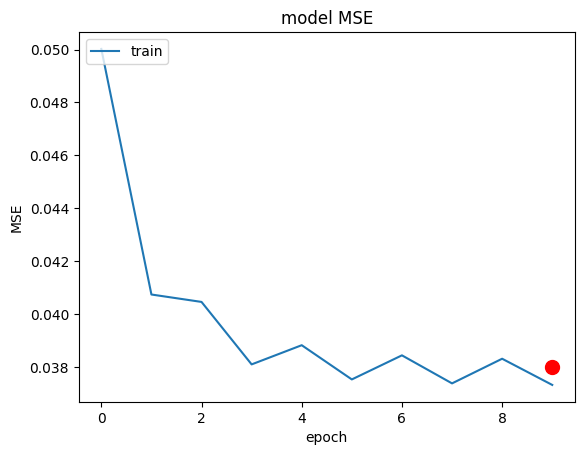

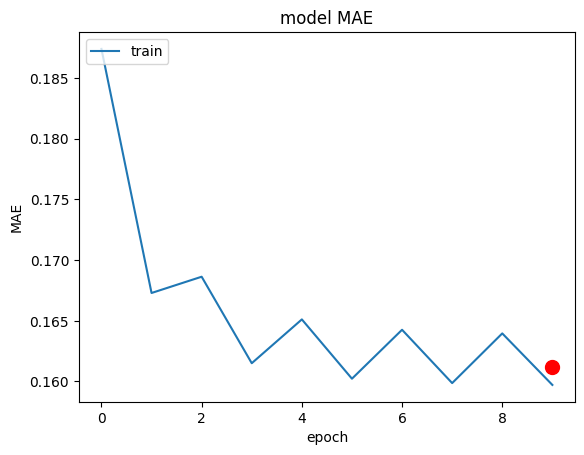

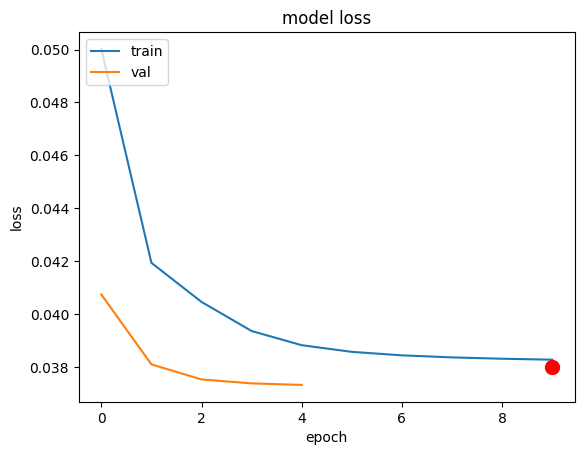

done with hyper-param search
2025-05-23T02:01:33.302367-07:00


In [21]:
## print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())
# note that the ratings have been normalized from ratings in range 0.5, 5.0
# to 0.1, 1.0
# therefore, any rated movie will be at most different from its rating by 0.9.
# one can expect that the worst mse would then be 0.9**2 = 0.81  
 
#while TF2 uses eager mode by default, keras does not,
# so can set keras to eager mode globally with this after import keras: 
# tf.config.experimental_run_functions_eagerly
# or set each Keras Model to use eager during compile as an option

#from Gemini:
def print_weights_recursively(model, loaded_model, prefix=""):
     
    thresh_diff = 1E-4

    """Prints the weights of a TensorFlow model recursively, including nested models."""
    for i, layer in enumerate(model.layers):
        sub_prefix = f"{prefix}{layer.name}/"
        loaded_layer = loaded_model.layers[i]
        if hasattr(layer, 'layers'):  # Check if it's a nested model
            print(f"{prefix}Nested Model: {layer.name}")
            print_weights_recursively(layer, loaded_layer, sub_prefix)
        else:
            weights = layer.get_weights()
            loaded_weights = loaded_layer.get_weights()
            if weights:
                print(f"{prefix}Layer: {layer.name}")
                for j, w in enumerate(weights):
                    l_w = loaded_weights[j]
                    #print(f"{sub_prefix}Weight {j}: shape={w.shape}")
                    #print(f"{w :.4e}\n")
                    diff = w - l_w
                    max_diff = np.max(np.abs(diff))
                    if max_diff > thresh_diff:
                        print(f"max_diff={max_diff:.2e} in {sub_prefix}[{j}]\n")
                        print(f"  diff =       {diff}\n")
                    
if train_state == TrainState.DEBUG:
    import shutil
    try:
        shutil.rmtree(models_dir)
        print(f"Deleted: {models_dir}")
    except OSError as e:
        print(f"Error deleting {models_dir}: {e}")
    try:
        shutil.rmtree(working_dir + 'tests/')
        print(f"Deleted: {working_dir + 'tests/'}")
    except OSError as e:
        print(f"Error deleting {working_dir + 'tests/'}: {e}")
    try:
        shutil.rmtree(working_dir + 'tmp/')
        print(f"Deleted: {working_dir + 'tmp/'}")
    except OSError as e:
        print(f"Error deleting {working_dir + 'tmp/'}: {e}")

if not os.path.exists(models_dir):
    os.mkdir(models_dir)
    
label = 'rating'

#TODO: clean this up after config for TPU
sample_size = n_train # 400_000
if train_state == TrainState.DEBUG:
    batch_size = 64
    sample_size = 400_000

#TODO: make the unused portion of val available to the tests in lower sections
n_val_test = (int)(0.2*sample_size)

ds_ratings_train, ds_ratings_val, ds_ratings_test, ds_movies = get_ratings_model_tensors()

print(f"using {sample_size} of {n_train} train data")
ds_train = ds_ratings_train.take(sample_size).prefetch(tf.data.AUTOTUNE).map(lambda x: extract_labelX(x, label))
ds_val = ds_ratings_val.take(n_val_test).prefetch(tf.data.AUTOTUNE).map(lambda x: extract_labelX(x, label))
ds_test = ds_ratings_test.take(n_val_test).prefetch(tf.data.AUTOTUNE).map(lambda x: extract_labelX(x, label))
print(f'spec={ds_train.element_spec}\n')

print(f'have tensors, batch_size={batch_size}, sample_size={sample_size}\nds_ratings_train={ds_ratings_train}')

def compose_filename(params : dict) -> str:
    _layer_str = "_".join(str(x) for x in params['layer_sizes'])
    _filename = f"tt_em_{params['embed_out_dim']}_lr_{params['lr']}_reg_{params['regl2']}" + \
        f"_drop_{params['drop_rate']}_layer_{_layer_str}_fa_{params['feature_acronym']}" + \
        f"_ep_{params['num_epochs']}_bs_{params['batch_size']}_bc_{params['use_bias_corr']}" + \
        f"_ex_{params['n_examples']}_ge_{params['incl_genres']}"
    return _filename

def run_model(params : dict, best : dict):
    embed_out_dim = params["embed_out_dim"]
    lr = params["lr"]
    regl2 = params["regl2"]
    drop_rate = params["drop_rate"]
    layer_sizes = params["layer_sizes"]
    feature_acronym = params["feature_acronym"]
    num_epochs = params["num_epochs"]
    batch_size = params["batch_size"]
    use_bias_corr = params["use_bias_corr"]
    incl_genres = params['incl_genres']

    summary_printed = False
    
    reg = None if regl2==None else keras.regularizers.L2(regl2)

    #writes to a sub-directory in the kaggle working directory
    _filename = compose_filename(params)
    filepath = os.path.join(models_dir, f'{_filename}.keras')
    
    model_exists = os.path.exists(filepath)
    print(f'model_exists={model_exists}\n')

    input_shapes = {}
    for element in ['user_id', 'movie_id', 'age_group', 'gender', 'hr_bin', 'occupation', 'rating', 'genres']:
        input_shapes[element] = (None,)
        #input_shapes[element] = (batch_size,)

    # Create the model, optimizer and metrics inside the `tf.distribute.Strategy`
    # scope, so that the variables can be mirrored on each device.
    with strategy.scope():
        
        if use_bias_corr:
            optimizer = keras.optimizers.SGD(learning_rate=lr)
        else:
            optimizer = keras.optimizers.Adam(learning_rate=lr)
            def scheduler(epoch):
                if epoch < 8:
                    return 1e-5
                else:
                    return 1e-6
            #lr_sched_callback = keras.callbacks.LearningRateScheduler(scheduler)
            #callbacks.append(lr_sched_callback)        

        print(f'hyperparams: {params}\n')
        
        if model_exists:
            model = keras.models.load_model(filepath)
        else:
            model = TwoTowerDNN(n_users=user_id_max + 1, \
                n_movies=movie_id_max + 1, n_genres=len(genres), layer_sizes=layer_sizes, embed_out_dim=embed_out_dim, \
                reg=reg, drop_rate=drop_rate, feature_acronym=feature_acronym,\
                use_bias_corr=use_bias_corr, incl_genres=incl_genres)
        if not model_exists:
            model.build(input_shapes)
        # the losses are now custom calculated in train_step and test_step
        model.compile(
            #loss = keras.losses.BinaryCrossentropy(),
            loss = keras.losses.MeanSquaredError(),
            optimizer=optimizer,
            metrics=[keras.metrics.MeanSquaredError(name="mse"), keras.metrics.MeanAbsoluteError(name="mae")],
            run_eagerly=run_eagerly
        )

    #logging and checkpointing should be done from one host
    
    early_stopping_callback = keras.callbacks.EarlyStopping(\
        #monitor="loss", \
        monitor="val_loss", \
        #monitor="val_mean_squared_error", \
        mode="min",\
        min_delta=2E-3, patience=3, restore_best_weights=True)

    callbacks = [early_stopping_callback]

    if run_eagerly: #have to use model_checkpoint_callback else the backup and restore callback
        callback = keras.callbacks.ModelCheckpoint(\
            filepath=filepath, monitor='val_loss', verbose=1, mode='min', save_best_only=True,\
            save_weights_only=False, save_freq='epoch')
        callbacks.append(callback)
    else:
        #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/BackupAndRestore
        backup_filepath = os.path.join(models_dir, f'{_filename}_backup')
        callback = keras.callbacks.BackupAndRestore(backup_dir=backup_filepath,\
            save_freq='epoch', delete_checkpoint=True)
        callbacks.append(callback)
    
    history = model.fit(ds_train,\
        epochs=num_epochs, \
        batch_size=batch_size, \
        validation_data=ds_val,\
        verbose=2, \
        callbacks = callbacks, \
        validation_freq=2, \
    )

    #print(f'history.history={history.history}\n')

    test_dict = model.evaluate(x=ds_test, \
        #batch_size=batch_size, \
        verbose=2, return_dict = True\
    )
    #transform test_dict values into scalars, and bring tested to top level
    tmp = {}
    for key in test_dict:
        _key = key.replace("test_", "")
        if isinstance(test_dict[key], tf.Tensor):
            tmp[_key] = test_dict[key].numpy()
        elif isinstance(test_dict[key], dict):
            for key2 in test_dict[key]:
                _key2 = key2.replace("test_", "")
                if isinstance(test_dict[key][key2], tf.Tensor):
                    tmp[_key2] = test_dict[key][key2].numpy()
                else:
                    tmp[_key] = test_dict[key]
        else:
            tmp[_key] = test_dict[key]
    test_dict = tmp
    #test_dict keys should now be: 'loss', 'mse', 'mae'
        
    print(f'{count}: current model params = {_filename}\ntest: {test_dict}\n')
        
    if best["params"] is None or best["test_results"]["loss"] > test_dict['loss']:
        best["test_results"] = test_dict.copy()
        best["model"] = model
        best["filepath"] = filepath
        best["params"] = params.copy()
        print(f'*** BEST H-PARAMS SO FAR ***: {_filename}\n')

        test_filepath = filepath.replace(".keras", "_test.txt")
        with open(test_filepath, 'w') as the_file:        
            for key in best["test_results"]:
                the_file.write(f'{key}:{best["test_results"][key]}\n')

        print(f'history {history.history}\n')
        
        #history.history={'loss': [0.6714571118354797, 0.6667017936706543], 
        #  'val_loss': [0.7185271382331848, 0.7184299826622009]}
        
        lx = len(history.history['loss']) - 1
                        
        if not summary_printed:
            keras.utils.plot_model(model, to_file='model.png', show_shapes=True, \
                show_dtype=False, show_layer_names=False, rankdir='TB', \
                expand_nested=True, dpi=200, show_layer_activations=False, \
                show_trainable=False)
            print("printing model summaries")
            model.summary()
            model.query_model.summary()
            model.candidate_model.summary()
            model.query_model.embedding_model.summary()
            model.candidate_model.embedding_model.summary()
            print("done printing model summaries")
            summary_printed = True

        #dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])
        if 'mse' in history.history:
            plt.plot(history.history['mse'])
            if "val_mse" in history.history:
                plt.plot(history.history['val_mse'])
            if "mse" in best["test_results"]:
                plt.plot(lx, best["test_results"]["mse"], marker='o', markersize=10, color='red', label='test')
            plt.title('model MSE')
            plt.ylabel('MSE')
            plt.xlabel('epoch')
            if "val_mse" in history.history:
                plt.legend(['train', 'val'], loc='upper left')
            else:
                plt.legend(['train'], loc='upper left')
            plt.show()
        if 'mae' in history.history:
            plt.plot(history.history['mae'])
            if "val_mae" in history.history:
                plt.plot(history.history['val_mae'])
            if "mae" in best["test_results"]:
                plt.plot(lx, best["test_results"]["mae"], marker='o', markersize=10, color='red', label='test')
            plt.title('model MAE')
            plt.ylabel('MAE')
            plt.xlabel('epoch')
            if "val_mae" in history.history:
                plt.legend(['train', 'val'], loc='upper left')
            else:
                plt.legend(['train'], loc='upper left')
            plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        if "loss" in best["test_results"]:
            plt.plot(lx, best["test_results"]["loss"], marker='o', markersize=10, color='red', label='test')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

# see https://www.tensorflow.org/tfx/model_analysis/metrics#multi-classmulti-label_classification_metrics
lrs = [1E-4]
regs = [None]#, 0.001, 0.01]
drop_rates = [1E-1]# up to 5E-1]
num_epochs = 10#30
embed_out_dims = [32] #roughly, 70 is max feasible for this dataset 
layer_sizes_lists = [[32]]#[[64, 32]]
#"ahos" for "age_group", "hrs_bin", "occupation", "gender", respectively
feature_acronym = ""
incl_genres = True

count = 0
#DEBUGGING
if train_state == TrainState.DEBUG:
    lrs = [1E-6]
    regs = [regs[0]]
    drop_rates = [1E-1] #for small batch_sizes, may not need regularization
    num_epochs = 20
    embed_out_dims = [16]
    layer_sizes_lists = [[16]]
    incl_genres = False
    
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())
print("begin hyper-param search")

best = {"params" : None, "model" : None, "filepath" : None}

params = {'use_bias_corr': use_bias_corr, 'feature_acronym' : feature_acronym, \
    'num_epochs' : num_epochs, 'batch_size' : batch_size, 'n_examples' : sample_size, \
    'incl_genres' : incl_genres}

for embed_out_dim in embed_out_dims:
    params['embed_out_dim'] = embed_out_dim
    for layer_sizes in layer_sizes_lists:
        params['layer_sizes'] = layer_sizes
        for lr in lrs:
            params['lr'] = lr
            for regl2 in regs:
                params['regl2'] = regl2
                for drop_rate in drop_rates:
                    params['drop_rate'] = drop_rate
                    run_model(params, best)
                    count += 1

print("done with hyper-param search")
if best["model"]:
    keras.utils.plot_model(best["model"], show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=False)

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

# batch_size exploration for saturation

#### quick look at results for num_epochs=20 on laptop (4GB RAM, dual core, 1.3GHz) 

the sample sizes are too small, but need to explore before estimating train time for 
larger sample sizes.

early stopping is used when val_loss does not improve within 1E-3 for 3 epochs

fa="a"

Table headers:
* embed = embed_out_dim
* layers = layers_size
* lr = learning rate of Adam optimizer
* bsz = batch_size
* sszf = sample_size factor.  sample_size = sszf x bsz
* et = time for 1 epoch train
* last = last epoch out of 20
* tloss = test_loss
* dloss = delta loss at last step if still significant.  that means more than 20 epochs are needed
* ntr = number of trainable params in the TwoTowerDNN model

These numbers are from the Keras2 configuration.  See below for the keras 3 configuration results.

| embed | layers |  lr      | bsz   | sszf      |   et    | last   | tlos | dloss   |
|:-----:|:------:|:--------:|:-----:|:---------:|:-------:|:------:|:----:|:-------:|
| 32    | [32]   | 1E-5     | 64    |   10x     |  5 s    |  20    |0.989 |         |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    | [32]   | 1E-4     | 64    |   10x     |  5 s    |  20    |      |         |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    | [32]   | 1E-5     | 64    |  100x     |  50 s   |  10    |0.597 |         |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    | [32]   | 1E-6     | 64    |  100x     |  50 s   |  20    |0.844 |   0.15  |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    | [32]   | 1E-6     | 64    | 1000x     | 550 s   |  20    |      |         |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    |[64,32] | 1E-6     | 64    |  100x     | 70 s    |  20    |0.611 |   1E-3  |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|
| 32    |  [32]  | 1E-5 < 5 | 64    |  100x     | 50 s    |  16    |0.603 |   1E-3  |
|       |        | else 1E-6|       |           | 60 s    |        |      |         |
|-------|--------|----------|-------|-----------|---------|--------|------|---------|


* changing early stopping to 1E-2 for val_loss


| embed | layers |  lr      | bsz   | sszf      |   et    | last   | tlos |       ntr   |
|:-----:|:------:|:--------:|:-----:|:---------:|:-------:|:------:|:----:|:-----------:|
| 64    | [32]   | 1E-5     | 64    |  100x     |  ?  s   |  11    | 0.601|  643,936    |
|-------|--------|----------|-------|-----------|---------|--------|------|-------------|
| 16    | [32]   | 1E-5     | 64    |  100x     |  45 s   |   9    | 0.603|  161,056    |
|-------|--------|----------|-------|-----------|---------|--------|------|-------------|
|  8    | [8]    | 1E-5     | 64    |  100x     |  45 s   |   10   | 0.603|   80,120    |
|-------|--------|----------|-------|-----------|---------|--------|------|-------------|
|  8    | [8]    | 1E-5     | 64    |  1000x    | 380 s   |   4    | 0.604|   80,120    |
|-------|--------|----------|-------|-----------|---------|--------|------|-------------|

* Kaggle CPU has processor twice as fast as my laptop w/ several times more memory and completes the same run about 2 times as fast as the laptop table above (spot checked).
* Kaggle GPU GPU T4X2 completes same job about 1.5 times as fast as the laptop table above (spot checked)
* Kaggle TPU: not currently avail

### Re-doing for Keras3 (previously configured for tk-keras, keras2 to try TPU settings that work on colab TPU)
* looking for where the increasing batch_size saturates, that is, a factor of 2 increase in batch_size leads to a significantly longer epoch time.

| embed | layers |  lr      | bsz   | sample sz | epoch t |tstlos | num tr pars |
|:-----:|:------:|:--------:|:-----:|:---------:|:-------:|:-----:|:-----------:|
|  8    | [8]    | 1E-5     | 64    |  6400     |  36 s   |  0.61 |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 16    |  100_000  |  400  s | 0.61  |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 32    |  100_000  |  430  s | 0.60  |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 64    |  100_000  |  550  s |  0.60 |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 128   |  100_000  |  640 s  | 0.60  |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 256   |  100_000  |  640 s  | 0.60  |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|
|  8    | [8]    | 1E-5     | 512   |  100_000  | 2245 s  |       |   80,120    |
|-------|--------|----------|-------|-----------|---------|-------|-------------|

## Re-doing for addition of genres to MoviesModel and pre-fetch:
number of trainable params ~ 8E4.

batch_size exploration for sample size.

| embed | layers |  lr      | bsz   |sample sz  |   et    | last   | tlos | 
|:-----:|:------:|:--------:|:-----:|:---------:|:-------:|:------:|:----:|
|  8    | [8]    | 1E-5     | 16    | 100_000   | 450  s  |   5    | 0.62 |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  8    | [8]    | 1E-5     | 16    |  10_000   |  36  s  |   5    | 0.62 |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 16    |  10_000   |  36  s  |   5    | 0.62 |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 8     | 200_000   | 1000 s  |   4    | 0.60 |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 16    | 200_000   | 1060 s  |   4    | 0.60 |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 32    | 200_000   | 1080 s  |        | 0.xx |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 64    | 200_000   | 1151 s  |        | 0.xx |
|-------|--------|----------|-------|-----------|---------|--------|------|
|  16   | [16]   | 1E-5     | 128   | 200_000   | 1378 s  |        | 0.xx |
|-------|--------|----------|-------|-----------|---------|--------|------|

==> batch_size 64 is last before saturated for those parameters.

### Running all features and full training dataset
hyperparams: {'use_bias_corr': False, 'feature_acronym': 'ahos', 'num_epochs': 30, 'batch_size': 256, 'n_examples': 900189, 'embed_out_dim': 32, 'layer_sizes': [64, 32], 'lr': 1e-06, 'regl2': None, 'drop_rate': 0.1}
* mae: 0.1598 - mse: 0.0374 for val at 6 epochs end, though the lr was too high and/or batch size too low and might need more regularization as seen from a little instability in the loss curve.

### which is not better than the simpler model as speculated after the EDA charts.
hyperparams: {'use_bias_corr': False, 'feature_acronym': '', 'num_epochs': 30, 'batch_size': 256, 'n_examples': 900189, 'incl_genres': False, 'embed_out_dim': 32, 'layer_sizes': [32], 'lr': 1e-06, 'regl2': None, 'drop_rate': 0.1}
* mae: 0.1594 - mse: 0.0372



In [22]:
import platform
is_linux = platform.system().lower() == "linux"
model = best["model"]

persist_best_dict(models_dir, best)

_tmp = best["filepath"].replace(".keras","")

model.save(filepath=best["filepath"], overwrite=True, zipped=True)

#save to reachable kaggle location
if is_linux:
    now = datetime.datetime.now()
    year = now.year
    month = now.month
    day = now.day
    _path = f"/kaggle/working/ttdnn{year}_{month:02d}_{day:02d}.keras"
    model.save(filepath=_path, overwrite=True, zipped=True)

if not shuffle_data:    
    restored_model = keras.models.load_model(filepath = best["filepath"], compile=False, safe_mode=True)
    print_weights_recursively(model, restored_model,"")
    np.testing.assert_allclose(
        model.predict(x=ds_test, batch_size=batch_size, verbose=2),
        restored_model.predict(x=ds_test, batch_size=batch_size, verbose=2)
    )

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-23T02:01:33.738499-07:00


# Install ScANN or FAISS for scalable nearest neighbors search libraries
ScANN easy install for linux platform (needs build steps for macos)

FAISS easy install for linux os, ms os, and macos 

In [23]:
import platform
is_linux = platform.system().lower() == "linux"
FAISS_INSTALLED = False
SCANN_INSTALLED = False

@keras.saving.register_keras_serializable(package="", name="install_import_FAISS")
def install_import_FAISS():
    global FAISS_INSTALLED
    if not FAISS_INSTALLED:
        if device == Device.GPU:
            # GPU detected, install GPU-optimized libraries
            !pip install faiss-gpu
        else:
            # CPU detected, install CPU-only libraries
            !pip install -q faiss-cpu
        import faiss
        print(faiss.__version__)
        FAISS_INSTALLED = True

@keras.saving.register_keras_serializable(package="", name="install_import_ScANN")
def install_import_ScANN():
    global SCANN_INSTALLED
    if not SCANN_INSTALLED:
        # version 1.3.5 is compatible with tf 2.18.0
        # version 1.4.0 is compatible with tf 2.19.0
        !pip install -q scann==1.3.5
        import scann
        SCANN_INSTALLED = True

@keras.saving.register_keras_serializable(package="", name="build_scann_searcher")
def build_scann_searcher(embeddings : np.ndarray, top_k: int):
    '''
    build an ScANN indexer initialized with embeddings, and top_k number of nearest neighbors,
    and the brute force algorithm.
    TODO: tune configuration for high performance and accuracy.

    Usage: neighbors, distances = searcher.search_batched(query_embedding)

    to use scann.
    # https://github.com/google-research/google-research/blob/master/scann/docs/example.ipynb
    # https://github.com/google-research/google-research/blob/master/scann/docs/algorithms.md
    '''
    if embeddings.dtype != np.float32:
        raise Exception(f'embeddings must be dtype np.float32\n')
    install_import_ScANN()
    import scann
    n = len(embeddings)
    searcher = scann.scann_ops_pybind.builder(\
        embeddings, top_k, "dot_product")\
        .score_brute_force(quantize=False).build()
    return searcher

@keras.saving.register_keras_serializable(package="", name="build_faiss_index")
def build_faiss_index(embeddings : np.ndarray, dimension: int):#, ids: np.ndarray, dimension: int):
    dimension = int(dimension)
    if dimension < 1:
        raise Exception(f'dimension must be an integer > 0. dimension={dimension}\n')
    if embeddings.dtype != np.float32:
        raise Exception(f'embeddings must be dtype np.float32\n')
    install_import_FAISS()
    import faiss
    '''
    Usage:
    distances, top_ids = index.search(query, k)
    distances = distances.reshape(-1)
    top_ids = top_ids.reshape(-1)
    
    to speed up performance, try:
    nlist = 100  # Number of clusters
    quantizer = faiss.IndexFlatL2(dimension)
    index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
    index.train(normalized_vectors)
    index.add(normalized_vectors)

    '''
    index = faiss.IndexFlatIP(dimension)  # IP for inner product.  search is cosine similarity
    #\index = faiss.IndexIDMap2(index)
    #movie_embeddings = np.reshape(movie_embeddings, (-1, np.shape(movie_embeddings)[2]))
    # print(f'shape movie_embeddings = {np.shape(movie_embeddings)}\n')
    # movie_embeddings shape is (num_movies, embed_dim)
    #print(f'len of embeddings, ids = {len(movie_embeddings), len(_movie_ids)}\n')
    #index.add_with_ids(embeddings, ids)  # self.movie_ids)
    index.add(embeddings)  # self.movie_ids)
    return index

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-23T02:01:34.008938-07:00


# Build a Retrieval class
for user-to-item and item-to-item queries

In [24]:
#TODO: make class serializable.  
# https://keras.io/guides/serialization_and_saving/
#TODO: move the FAISS and ScANN code into this class

class Retrieval:
    '''
    class holding methods for retrieving recommended movie_ids and their scores,
    for queries by user or queries by movie.  
    
    internally, creates an ANN library of movie embeddings
    and a dictionary with keys = all known user_id and values = their
    query embeddings from 'user_id', 'hr_bin', 'gender', 'age_group', 'occupation'.

    NOTE: this class requires external methods build_scann_searcher and build_faiss_index
    to be within external scope, invocable by methods in this class.
    they set a couple of global params so nice to not reduce their scopes for now,
    TODO:  that should change when tests are refactored.  this class should be independtly 
    serializable...

    TODO: ideally, if very large number of movies and users, this class should be split into
    a keras or SavedModel for serving predictions for user queries and 
    another for serving predictions for item queries, and they would use caching, and
    fast cloud storage for the user information lookups.

    Args:
       trained_model: the trained TwoTowerDNN
       
       movies: a pandas DataFrame or tensorflow Dataset of all movies to be searched.

       users: file path to ratings_train.csv file, e.g. proj_dir + "ratings_train.csv"
       
       k : the number of movies to return for a query.  i.e. k = 1000.  A Ranking model
       can further reduce and rank results.

       is_linux: true when the underlying platform OS is linux.  this is needed for ANN library
       package choice. 
    '''
    def __init__(self, trained_model : TwoTowerDNN, \
        movies : Union[pd.DataFrame, tf.data.Dataset], users: pd.DataFrame, k : int = 1000):
        '''
        Args:
            trained_model : an trained instance of TwoTowerDNN
            
            movies: a pandas DataFrame or tensorflow Dataset of 'movie_id'.  movie_id is currently the
                only item feature column.

            user: a pandas DataFrame containing the following columns:
                ['user_id', 'gender', 'age_group', 'occupation', 'zip_code', 'timezone']

            k : the number of nearest neighbors to retrieve
        '''
        k = int(k)
        if k < 1:
            raise Exception(f'k must be an integer > 0.  received k={k}\n')
        self.query_model = trained_model.query_model
        self.candidate_model = trained_model.candidate_model
        self.k = k
        import platform
        self.is_linux = platform.system().lower() == "linux"
        # the movie embedding ids are needed to lookup which movie is returned from indexer indexes
        self.movie_embedding_ids, self.indexer = self._create_indexer(movies, k)
        self.users_dict = self._create_users_dict(users)
    
    def _create_users_dict(self, users: pd.DataFrame) -> dict:
        '''
        create a dictionary with key = user_id, value = dictionary having columns
            ['user_id', 'gender', 'age_group', 'occupation', 'zip_code', 'timezone']

        Args
            users: a pandas DataFrame containing the following columns:
                ['user_id', 'gender', 'age_group', 'occupation', 'zip_code', 'timezone']

        Returns:
            a dictionary w/ key = user_id, value = dictionary of all of users columns
        '''
        _users_dict = users.to_dict('records')
        users_dict = {ele['user_id'] : ele  for i, ele in enumerate(_users_dict)}
        # TODO: these could instead be stored in fast cloud storage
        # and a cache w/ eviction strategies could be used in front of the storage, w/ fetch from
        # storage upon cache miss
        #DEBUG
        print(f'users={users_dict}\n')
        return users_dict

    def _resolve_movie_ids(self, neighbor_idxs):
        out = [self.movie_embedding_ids[q_idxs] for q_idxs in neighbor_idxs]
        return out
        
    def _calc_hr_bin(self, tz : str, ts : np.int32) -> np.int32:
        '''
        Args:
           tz : timezone string
           ts : timestamp
        '''
        utc_time = datetime.datetime.fromtimestamp(ts, tz=pytz.utc)
        timezone = pytz.timezone(tz)
        local_time = utc_time.astimezone(timezone)
        hr = int(np.round(local_time.hour + (local_time.minute/60.)))
        return np.max([0, (hr-1)//3])
        
    def _create_indexer(self, movies : Union[pd.DataFrame, tf.data.Dataset], k : int):
        '''
        create an ANN indexer instance populated w/ the movie (==item) embeddings.

        Args:
            movies: a pandas DataFrame or tensorflow Dataset of 'movie_id' and 'genres'.  

        Returns:
            a tuple of 2 item:
                (1) the ordered movie_ids array for the movie embeddings stored in the indexer.  
                the results from an ANN query to the indexer will have indexes of the movie_ids array
                to look-up the movie_ids.
                (2) the ANN indexer.

        TODO: consider storing the movie_embeddings in fast cloud storage w/ caching in between,
        in order to make the predictions faster
        '''
        if isinstance(movies, pd.DataFrame):
            movie_ids = movies['movie_id'].to_numpy()
            movie_genres = movies['genres'].to_numpy()
            movies = OrderedDict({'movie_id': movie_ids, 'genres': movie_genres})
        else:
            #TODO: test this batched input movies
            movie_ids = np.array([a for batch in movies for a in batch['movie_id'].numpy().to_list()])
            #n_movies = len(movie_ids)
            #movies = movies.unbatch().batch(batch_size=n_movies)

        #embeddings are np.ndarray
        movie_embeddings = self.candidate_model.predict(x=movies, batch_size=len(movie_ids))

        #DEBUG
        print(f'n_movies={len(movie_ids), np.shape(movie_embeddings)}\n')
        
        if self.is_linux:
            indexer = build_scann_searcher(embeddings=movie_embeddings, top_k=k)
        else:
            d = np.shape(movie_embeddings)[1]
            indexer = build_faiss_index(embeddings=movie_embeddings, \
                #ids=movie_embedding_ids, 
                dimension=d)
        return movie_ids, indexer

    def predict_movies_for_users(self, user_ids : Union[list, np.ndarray]):
        '''
        Returns:
            a tuple of (list of movie_ids predicted, list of the cos sim distances)
        '''    
        if len(user_ids) == 0:
            raise Exception("received 0 users for predict_movies_for_users()")
            
        columns = ['user_id', 'gender', 'age_group', 'occupation', 'hr_bin']
        vecs = {key:[] for key in columns}
        for user_id in user_ids:
            _dict = self.users_dict.get(user_id, None)
            if not _dict:
                raise Exception(f"user_id {user_id} not found in db. use a movie based method if possible\n")
            for key in columns:
                if key != 'hr_bin' or key in _dict:
                    vecs[key].append(_dict[key])
                else:
                    if key != 'hr_bin':
                        raise Exception(f"missing key {key} in users data from constuction\n")
                    # need Unix timestamp (seconds since the epoch) for this moment
                    if 'timestamp' in _dict:
                        timestamp = _dict['timestamp']
                    else:
                        now_datetime = datetime.datetime.now()
                        timestamp = int(now_datetime.timestamp())
                    hr_bin = self._calc_hr_bin(_dict['timezone'], timestamp)
                    vecs['hr_bin'].append(hr_bin)
        for key in columns:
            vecs[key] = np.array(vecs[key])
        vecs = OrderedDict(vecs)
        
        q_emb = self.query_model.predict(x=vecs, batch_size=len(user_ids))        
        return self._predict_movies(q_emb)

    def predict_movies_for_user_ratings(self, user_ratings : Union[list, np.ndarray]):
        '''
        Args:
            user_ratings: a list of dictionaries containing keys 'user_id', 'movie_id', 'timestamp', 'rating'.
            currently, only the user_id and timestamp are used
        Returns:
            a tuple of (list of movie_ids predicted, list of the cos sim distances)
        '''
        if len(user_ratings) == 0:
            raise Exception("received 0 users for predict_movies_for_user_ratings()")
            
        columns = ['user_id', 'gender', 'age_group', 'occupation', 'hr_bin']
        vecs = {key:[] for key in columns}
        for user_dict in user_ratings:
            user_id = user_dict['user_id']
            _dict = self.users_dict.get(user_id, None)
            if not _dict:
                raise Exception(f"user_id {user_id} not found in db. use a movie based method if possible\n")
            for key in columns:
                if key != 'hr_bin':
                    vecs[key].append(_dict[key])
                else:
                    if key != 'hr_bin':
                        raise Exception(f"missing key {key} in users data during constuction\n")
                    if 'timestamp' in user_dict:
                        timestamp = user_dict['timestamp']
                    else:
                        now_datetime = datetime.datetime.now()
                        timestamp = int(now_datetime.timestamp()) 
                    hr_bin = self._calc_hr_bin(_dict['timezone'], timestamp)
                    vecs['hr_bin'].append(hr_bin)
        for key in columns:
            vecs[key] = np.array(vecs[key])
        vecs = OrderedDict(vecs)
        q_emb = self.query_model.predict(x=vecs, batch_size=len(user_ids))        
        return self._predict_movies(q_emb)

    def _predict_movies(self, q_emb):
        '''
        Args:
            q_emb: an embedding that is a user based embedding or a movie based embedding,
            constructed from self.query_model or self.candidate_model, respectively.
        '''
        if len(q_emb) == 0:
            raise Exception("received 0 q_emb for _predict_movies()")
            
        if not isinstance(q_emb, np.ndarray):
            print(f'q_emb must be an numpy ndarray\n')
        if q_emb.dtype != np.float32:
            raise Exception(f'q_emb must be dtype np.float32\n')
        #if not q_emb or len(q_emb) == 0:
        #    return np.array([]), np.array([])
        if self.is_linux:
            neighbor_idxs, distances = self.indexer.search_batched(q_emb)
        else:
            try:
                distances, neighbor_idxs = self.indexer.search(q_emb, self.k)
            except Exception as ex:
                '''print(f'qemb=np.array([', end='')
                for qlist in q_emb:
                    print(f'[', end='')
                    for i, q in enumerate(qlist):
                        print(f'{q:.6f},', end='')
                    print(f'],', end='\n')
                print(f'])', end='\n') '''      
                print(f'ERROR shape={np.shape(q_emb), type(q_emb)}, k={self.k}\n')
                raise ex
        dist_movie_ids = self._resolve_movie_ids(neighbor_idxs)
        return dist_movie_ids, distances
        
    def predict_movies_for_movies(self, movie_ids : Union[list, np.ndarray], movie_genres: Union[list, np.ndarray]):
        '''
        given a list of movie_ids and their genres, returns a tuple of (movie ids, cosine similarity distances)
        for the k nearest neighbors.
        '''
        if len(movie_ids) == 0:
            raise Exception("received 0 movie_ids for predict_movies_for_movies()")
        #TODO consider storing the movie embeddings created in _create_indexer
        # so they are available for lookup here instead of recreating them
        if isinstance(movie_ids, list):
            movie_ids = np.array(movie_ids)
            movie_genres = np.array(movie_genres)
        vecs = OrderedDict({'movie_id': movie_ids, 'genres': movie_genres})
        q_emb = self.candidate_model.predict(x=vecs, batch_size=len(movie_ids))        
        return self._predict_movies(q_emb)

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-23T02:01:34.301012-07:00


# Build and run a few tests

(see details above)

In [25]:
import scipy.stats

print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())
print('begin tests')

#TODO: add tests for Retrieval.predict_movies_for_movies

movies = pd.read_csv( \
    os.path.join(inp_proj_dir, "movie_candidates.csv"), \
    sep="|", \
    names=["movie_id", "genres"], \
    dtype={'movie_id': np.int32, 'genres': object}, \
    encoding="ISO-8859-1", \
    engine="python", \
)

#needs to be 32 bit:
n_movies = int(movies['movie_id'].count())
print(f"n_movies={n_movies}")

#map the genres as a string:
movie_id_to_genres_dict = dict(zip(movies['movie_id'], movies['genres']))

def transform_genres_to_mh(entry):
    _m = np.zeros(len(genres))
    for v in entry:
        _m[int(v)] = 1.0
    return _m

import heapq
class Row:
    def __init__(self, ratio, row):
        self.row = row
        self.ratio = ratio
    def __lt__(self, other):
        return self.ratio < other.ratio
    def __repr__(self):
        return f"Row(row='{self.row}', ratio={self.ratio})"

class FixedSizeMaxHeap:
    def __init__(self, max_size):
        self.max_size = max_size
        # list of Row
        self.heap = []
    def push(self, item : Row):
        if len(self.heap) < self.max_size:
            heapq.heappush(self.heap, item)
        elif item > self.heap[0]: #pops the smallest item
            heapq.heapreplace(self.heap, item)
    def get_heap(self):
        return self.heap
        
#count the number of movies having a single genre
#single_genre_movie_counts_dict = OrderedDict((movies[movies['genres'].str.find("|")==-1])['genres'].value_counts().to_dict())
#out of 3883 movies, 2025 have only 1 genre
"""
Drama          843
Comedy         521
Horror         178
Documentary    116
Thriller       101
Action          65
Romance         40
Western         33
Sci-Fi          27
Crime           26
Musical         18
Adventure       17
War             12
Mystery         10
Film-Noir       10
Children's       5
Animation        2
"""

#load the potentially sub-sample ds_train into a ratings df
ds_train_x = ds_train.map(lambda x, y: x)
columns = [key for key in ds_train_x.element_spec.keys()]
#editing
huge_dict = {key : [] for key in ds_train_x.element_spec.keys()}
tf.config.run_functions_eagerly(True)
for i, row in enumerate(ds_train_x):
    if i == 2: break
    for key in columns:
        v = row[key].numpy().tolist()
        huge_dict[key].extend(v)
tf.config.run_functions_eagerly(False)
user_ratings_train = pd.DataFrame.from_dict(huge_dict)
huge_dict = None
print(f"created df user_ratings_train from ds_train\n")
user_ratings_train['age_group'] = user_ratings_train['age_group'].astype(np.int32)
user_ratings_train['gender'] = user_ratings_train['gender'].astype(np.int32)
user_ratings_train['hr_bin'] = user_ratings_train['hr_bin'].astype(np.int32)
user_ratings_train['movie_id'] = user_ratings_train['movie_id'].astype(np.int32)
user_ratings_train['occupation'] = user_ratings_train['occupation'].astype(np.int32)
user_ratings_train['user_id'] = user_ratings_train['user_id'].astype(np.int32)
user_ratings_train['timestamp'] = user_ratings_train['timestamp'].astype(np.int32)
user_ratings_train['rating'] = user_ratings_train['rating'].astype(np.float32)

#insert genres column into ratings_train.  make a dictionary for faster search
user_ratings_train['genres'] = user_ratings_train['movie_id'].apply(lambda x : movie_id_to_genres_dict[x])
user_grouped = user_ratings_train.groupby('user_id')
count = user_grouped['rating'].count()
count.name = 'num_rated'
user_ratings_train = user_ratings_train.merge(right=count, on='user_id')

def define_test_users() -> dict:
    '''
    finds the test users.
    add a column to the data for the number of movies a user has rated in the train dataset.
    filters the data for movies that have only 1 genre.
    for each genre
        filters the data for ratings for that genre, counts the number for each user
        and makes a new column ratio = number of user's ratings for the genre / number of user's ratings
        then puts the max ratio on a heap if the ratio is >= 0.4
    the result is the test users.
    the recommendations for the test users are expected to be movies having the given genre.
        
    Returns:
       editing...
    '''
    # filter for movies that have only 1 genre (looking for fans of a genre)
    data2 = user_ratings_train[user_ratings_train['genres'].str.find(',')==-1].copy()
    data2['genres'] = data2['genres'].astype(np.int32)

    # find max of ratios for each genre where ratio is user's n_movies_in_genre_user/n_movies_user
    heap = FixedSizeMaxHeap(10)
    for g in range(len(genres)):
        d3 = data2[data2['genres'] == g]
        user_grouped = d3.groupby('user_id')
        count = user_grouped['user_id'].count()
        count.name = 'num_pure'
        d3 = d3.merge(right=count, on='user_id', how="left")
        d3 = d3[(d3['rating'] >= 0.8)]
        d3 = d3.drop_duplicates(subset=['user_id'], keep='first')
        d3['num_rated'] = d3['num_rated'].astype(np.float32)
        d3['num_pure'] = d3['num_pure'].astype(np.float32)
        d3['ratio'] = d3['num_pure'] / d3['num_rated']
        d3_sorted = d3.sort_values(by='ratio', ascending=False)
        if d3_sorted['ratio'].count()==0: continue
        tmp = d3_sorted.head(1)
        if tmp['ratio'].values[0] < 0.4: continue
        item = Row(ratio=tmp['ratio'].values[0], row=tmp)
        heap.push(item)
    results = heap.get_heap()
    
    test_user_dict = {}
    for result in results:
        user_id = result.row['user_id'].values[0]
        g = result.row['genres'].values[0]
        test_user_dict[user_id] = {'user_id':user_id, 'genres' : g, 'movie_id' : \
            result.row['movie_id'].values[0]}
        print(f'{user_id} genre:{g, genres[g]}')
    print(f'found {len(test_user_dict)} test users\n')

    return test_user_dict

test_user_dict = define_test_users()

#print(movies['genres'].head())
movies['genres_mh'] = movies['genres'].str.split(',')
movies['genres_mh'] = movies['genres_mh'].apply(transform_genres_to_mh)
movies['genres_mh'] = movies['genres_mh'].apply(lambda x: np.round(x / np.linalg.norm(x), decimals=3))#.reset_index()

#turn the genres string into an array with split:
user_ratings_train['genres'] = user_ratings_train['genres'].str.split(',')
user_ratings_train['genres_mh'] = user_ratings_train['genres'].apply(transform_genres_to_mh)
user_ratings_train['genres_w_all'] = user_ratings_train['genres_mh'] * user_ratings_train['rating']
df_u_wga = user_ratings_train.groupby('user_id')['genres_w_all'].apply(sum_vectors)\
    .apply(lambda x: np.round(x / np.linalg.norm(x), decimals=3)).reset_index()
user_ratings_train = user_ratings_train.drop('genres_mh', axis=1)
user_ratings_train = user_ratings_train.drop('genres_w_all', axis=1)
# replace genres_w_all values by df_u_wga' 
user_ratings_train = user_ratings_train.merge(df_u_wga, on='user_id', how='left') 

def create_user_df(test_user_dict:dict) -> pd.DataFrame:
    all_test_users = [k for k in test_user_dict]
    data2 = user_ratings_train[(user_ratings_train['user_id'].isin(all_test_users))].copy()
    # keep only the first user_id entry in data for use in making model query embeddings
    data2 = data2.drop_duplicates(subset=['user_id'], keep='first')
    np.testing.assert_equal(len(test_user_dict), data2['user_id'].count())
    return data2
    
df_test_users = create_user_df(test_user_dict) 

k = 100

def get_user_dataframe(user_ids : Union[list, np.ndarray]) -> pd.DataFrame :
    data = pd.read_csv( \
        os.path.join(inp_proj_dir, "users.csv"), \
        sep="|", \
        names=['user_id', 'gender', 'age_group', 'occupation', 'zip_code', 'timezone'], \
        dtype={'user_id':np.int32, 'gender':np.int32, 'age_group' : np.int32, \
            'occupation':np.int32, 'zip_code':str, 'timezone':str},\
        encoding="ISO-8859-1", \
        engine="python", \
    )
    data = data[(data['user_id'].isin(user_ids))]
    return data

# for expected movies, we need to quantify the similarity for which another vector is more 
# different than alike to our query vector.
# since we're using cosine similarity, we have cos(theta)=1 for most similar
# and -1 for most dissimilar and cos(theta) = 0 for orthogonal.
# We can consider a bound for the "alike set" is the similarity for cos(theta=45 degrees) on the hypersphere = 0.7071
# and so ANN embedding distances as similarities between 0.7071 and 1.0 will be the complete 
# "alike set" of movies for a query vector.
# that set is needed for use in hyper-geometric stats.

print(f'n_movies={n_movies}')

#index2 has the movie vectors as L2 normalized movie genres multi-hot vectors
def create_indexer2():
    movie_ids = movies['movie_id'].to_numpy()
    movie_embeddings = np.array(movies['genres_mh'].to_list(), dtype=np.float32)
    print(f"creating indexer2 with {len(movie_embeddings)} movies")
    if is_linux:
        indexer = build_scann_searcher(embeddings=movie_embeddings, top_k=n_movies)
    else:
        d = np.shape(movie_embeddings)[1]
        indexer = build_faiss_index(embeddings=movie_embeddings, \
            #ids=movie_embedding_ids, 
            dimension=d)
    return indexer, movie_ids
 
all_test_users = [k for k in test_user_dict]

#df_test_users is derived from ratings and holds w_genres_all
#df_test_users_2 is derived from users.csv

# contains 'user_id', 'gender', 'age_group', 'occupation', 'zip_code', 'timezone'
df_test_users_2 = get_user_dataframe(all_test_users)

np.testing.assert_equal(df_test_users_2['user_id'].count(), len(all_test_users))

#print(f'df_test_users_2={df_test_users_2}\n')

retrieval = Retrieval(trained_model = best["model"], movies = movies, users = df_test_users_2, k = n_movies)

indexer2, indexer2_ids = create_indexer2() #query is user genres_mh

cos_sim_dist_limit = np.sqrt(2)/2.

def resolve_movie_ids(neighbor_idxs, movie_ids):
    out = [movie_ids[q_idxs] for q_idxs in neighbor_idxs]
    return out

def get_model_movie_predictions(model : QueryModel, indexer, indexer_ids, \
    users_df) -> (list[list[np.int32]], list[list[np.float32]]):
    '''
    batch query of all test users for ANN movie matches using the trained model
    predicted query embeddings.

    Returns:
        a tuple of (list of lists of top k movie matches for the test users, list of lists
        of distances for the top k movie matches)

        the distances are cosine similarity distances.
    '''
    if users_df['user_id'].count() == 0:
        raise Exception("no users given to get_model_movie_predictions()")
        
    user_cols = set(['user_id', 'movie_id', 'age_group', 'gender', 'hr_bin', 'occupation'])
    ordered_dict_data = OrderedDict()
    for col_name, col_data in users_df.items():
        if col_name in user_cols:
            ordered_dict_data[col_name] = np.array(col_data.tolist())
    n_lines = users_df['user_id'].count()
    q_emb = model.predict(x=ordered_dict_data, batch_size=n_lines)
    #print(f'q_emb=\n{q_emb}\n')
    
    if is_linux:
        neighbor_idxs, distances = indexer.search_batched(q_emb)
    else:
        distances, neighbor_idxs = indexer.search(q_emb, n_movies)

    dist_movie_ids = resolve_movie_ids(neighbor_idxs, indexer_ids)
    return dist_movie_ids, distances

def get_genre_movie_ann(indexer, indexer_ids, users_df:pd.DataFrame, limit) -> (list[list[np.int32]], list[list[np.float32]]):
    '''
    batch query of all test users for ANN movie matches using the test user genres_w_all

    Returns:
        a tuple of (list of lists of movie matches for the test users, list of lists
        of distances for the top k movie matches)
        where only the results with distances >= sqrt(2)/2 are returned

        the distances are cosine similarity distances.
    '''
    if users_df['user_id'].count() == 0:
        raise Exception("no users given to get_genre_movie_ann()")
        
    queries = np.array(users_df['genres_w_all'].to_list())

    #print(f"get_genre_movie_ann: limit={limit:.6f}, n_movies={n_movies}, # q={len(queries)}\n")
    
    if is_linux:
        neighbor_idxs, distances = indexer.search_batched(queries)
    else:
        distances, neighbor_idxs = indexer.search(queries, n_movies)
    
    dist_keep = []
    nn_movie_ids_keep = []
    for i, q_dist in enumerate(distances):
        #only keep the q_dist > 0.7071
        indices = np.where(q_dist > limit)
        dist_keep.append(q_dist[indices])
        nn_idxs = neighbor_idxs[i]
        nn_idxs = nn_idxs[indices]
        nn_movie_ids_keep.append( indexer_ids[nn_idxs] )
    return nn_movie_ids_keep, dist_keep

def read_users_from_test_data(user_ids):
    data = pd.read_csv( \
        os.path.join(inp_proj_dir, "ratings_test.csv"), header = 0, \
        sep="|", \
        names=['user_id', 'movie_id', 'rating', 'timestamp',\
            'gender', 'age_group', 'occupation', 'timezone', 'hr_bin', 'genres'], \
        dtype={'user_id':np.int32, 'movie_id': np.int32, 'rating' : np.float32, \
            'timestamp':np.int32, 'hr_bin':np.float32, 'gender':np.int32, \
            'age_group' : np.int32, 'occupation':np.int32, 'timezone':str, 'genres':str},\
        encoding="ISO-8859-1", \
        engine="python", \
    )
    if len(user_ids) == 0:
        raise Exception("no users given to read_users_from_test_data")
        
    #reduce data to only entries containing test users
    data = data[(data['user_id'].isin(user_ids))]
    out = {}
    for user_id in user_ids:
        tmp = data[(data['user_id'] == user_id)]
        out[user_id] = (tmp['movie_id'].values, tmp['rating'].values)
    return out

model = best["model"]    

# CAVEAT: using Retrieval means that hrs_bin is populated using local time 'now'
# and so hrs bin will not be the same for indexer2  
result_movie_ids_1, result_distances_1 = retrieval.predict_movies_for_users(user_ids=all_test_users)

##query is user genres_w_all, db is unweighted movie genres.  filtered for > cos_sim_dist_limit
result_movie_ids_2, result_distances_2 = get_genre_movie_ann(indexer2, indexer2_ids, \
    df_test_users, cos_sim_dist_limit)

#dictionary w/ key=userid, val = dict of (movie_id array, rating array)
testuser_test_dict = read_users_from_test_data(all_test_users)

for i in range(len(result_movie_ids_1)):
    print(f"len(result_movie_ids_1[{i}])={len(result_movie_ids_1[i])}")
for i in range(len(result_movie_ids_2)):
    print(f"len(result_movie_ids_2[{i}])={len(result_movie_ids_2[i])}")
print("begin filtering out test user's recommended movies that were in train dataset (long process)")
#filter out the movies from result_* that were in ds_train
u_m_rm = {key : set() for key in testuser_test_dict}
for user_id in u_m_rm:
    data2 = user_ratings_train[(user_ratings_train['user_id'] == user_id)]
    m = data2['movie_id'].to_numpy().tolist()
    u_m_rm[user_id] = u_m_rm[user_id].union(m)

for user_id in testuser_test_dict:
    print(f"user {user_id} rated {len(u_m_rm[user_id])} train movies")
  
def filter(m_ids, dists):
    ids = []
    ds = []
    for i, user_id in enumerate(all_test_users):
        m_list = m_ids[i] 
        d_list = dists[i]
        out1 = []
        out2 = []
        for j, m_id in enumerate(m_list):
            if m_id not in u_m_rm[user_id]:
                out1.append(m_id)
                out2.append(d_list[j])
        ids.append(np.array(out1))
        ds.append(np.array(out2))
    return ids, ds
result_movie_ids_1, result_distances_1 = filter(result_movie_ids_1, result_distances_1)
result_movie_ids_2, result_distances_2 = filter(result_movie_ids_2, result_distances_2)

print('removed trained movies from recommended')
for i in range(len(result_movie_ids_1)):
    print(f"len(result_movie_ids_1[{i}])={len(result_movie_ids_1[i])}")
for i in range(len(result_movie_ids_2)):
    print(f"len(result_movie_ids_2[{i}])={len(result_movie_ids_2[i])}")
    
# get dictionary of movieid to genres for debugging
def get_movie_id_to_genres_dict():
    m = pd.read_csv( \
        proj_dir + "movies.dat", \
        sep="\t", \
        names=["movie_id", "title", "genres"], \
        dtype={'movie_id': np.int32, 'title': str, 'genres': str}, \
        encoding="ISO-8859-1", \
        engine="python", \
    )
    _dict = m.to_dict('records')
    return {ele['movie_id'] : ele  for i, ele in enumerate(_dict)}

movie_id_dict = get_movie_id_to_genres_dict()

#writing to working_dir/tmp/user_id/example_movie.txt
#                                   model_rec_movies.txt
#                                   unweighted_genres_movies.txt
#                                   weighted_genres_movies.txt
rec_dir = working_dir + 'tests/'
if not os.path.exists(rec_dir):
    os.mkdir(rec_dir)
print(f'writing test recommendations to directory={rec_dir}\n')

"""
stats:

Retrieval: k=n_movies, emb=candidate_model
indexer2: k=n_movies, emb=unweighted genres

search given test user info:
   model recommendation results, then limit to better than sqrt(2)/2
       then limit to k=100
   weighted genres results, then limit to better than sqrt(2)/2
       then limit to k=100
"""
def count_number_with_genre(movie_ids:list, genre:int)->int:
    count = 0
    _genre = genres[genre]
    for m_id in movie_ids:
        if movie_id_dict[m_id]['genres'].find(_genre) > -1:
            count += 1
    return count

#NOTE: these tests are deisgned for fully sampled ratings.
#      because the test users were selected from the full
#      train dataset

### analysis of test user predictions ###
for i in range(len(result_movie_ids_1)):
    user_id = df_test_users['user_id'].iloc[i]
    m_predictions = result_movie_ids_1[i]
    m_dist = result_distances_1[i] 
    ex_m_id = test_user_dict[user_id]['movie_id']
    example_movie_title = movie_id_dict[ex_m_id]['title']
    example_movie_genres = test_user_dict[user_id]['genres']
    print(f"\nuser_id={user_id}, total # predictions={len(m_dist)} to dist={m_dist[len(m_dist)-1] :.4f}\n", end='')
    print(f"    example movie={example_movie_title}, genre={genres[example_movie_genres]}\n")              
    
    user_dir = f"{rec_dir}{user_id}"
    if not os.path.exists(user_dir):
        os.mkdir(user_dir)

    with open(os.path.join(user_dir, "example_movie.txt"), 'w') as the_file:
        the_file.write(f'{ex_m_id}|{example_movie_title}|{example_movie_genres}, {genres[example_movie_genres]}\n')
    
    # predicted movies with dist >  cos_sim_dist_limit
    indices_predictions = np.where(m_dist > cos_sim_dist_limit)
    m_predictions_limited = m_predictions[indices_predictions]
    m_dist_limited = m_dist[indices_predictions]
    print(f'   k={len(m_predictions_limited)} for cos sim > 0.707\n', end='')
    print(f'   which is the # of high quality model predictions\n')

    # expected movies from unweighted genres with dist >  cos_sim_dist_limit
    indices_exp_2 = np.where(result_distances_2[i] > cos_sim_dist_limit)
    expected_2 = result_movie_ids_2[i][indices_exp_2]
    dist_2 = result_distances_2[i][indices_exp_2]

    #TODO: remove use's train movie ids from predicted, then count the intersection with
    #   the rest of the user's ratings that are not in their train dataset ratings
    
    #the search is for full depth of movies to explore depth of good recommendations
    # so we take only the top k=100 of those here for calc stats
    if len(m_predictions_limited) > k:
        m_predictions_limited = m_predictions_limited[:k]
        m_dist_limited = m_dist_limited[:k]
    
    if len(expected_2) > k:
        expected_2 = expected_2[:k]
        dist_2 = dist_2[:k]

    with open(os.path.join(user_dir, "model_rec_movies_limited.txt"), 'w') as the_file:
        for j, m_id in enumerate(m_predictions_limited):
            the_file.write(f'{movie_id_dict[m_id]}, dist={m_dist_limited[j]:.3f}\n')

    with open(os.path.join(user_dir, "model_rec_movies.txt"), 'w') as the_file:
        for j, m_id in enumerate(m_predictions):
            if j > 99:
                break
            the_file.write(f'{movie_id_dict[m_id]}, dist={m_dist[j]:.3f}\n')
           
    n_in_N = len(expected_2)
    x = np.sum(np.isin(m_predictions_limited, expected_2))
    [M, n, N]=[n_movies, n_in_N, k]
    p = scipy.stats.hypergeom.sf(x - 1, M, n, N)
    #we rule out the null hypothesis that the m_predictions are random chance if p < 0.5
    print(f'    # expected from unweighted genres search:{len(expected_2)}\n', end='')
    print(f'    # predicted containing genre {genres[example_movie_genres]} = {count_number_with_genre(m_predictions_limited, example_movie_genres)}\n', end='')
    print(f'    # predicted found in expected:{x}\n', end='')
    print(f'    predictions in unweighted genres:\n', end='')
    print(f'        we rule out chance={p < 0.5}\n', end='')

    with open(os.path.join(user_dir, "unweighted_genres_movies.txt"), 'w') as the_file:
        for j, m_id in enumerate(result_movie_ids_2[i]):
            the_file.write(f'{movie_id_dict[m_id]}, dist={result_distances_2[i][j]:.3f}\n')

    #TODO: revisit this as begin ranking model
    
    # pretend that ratings_test.csv includes ratings for items that the user was recommended and they rated.
    # of the m_predictions or m_predictions_limited, how many are in ratings_test?
    # assume k items were recommended to user also.
    # this is a toy exercise. in a real pipeline, one needs more information about the recommendations
    # TODO: correct to use all test user ratings that are not in train.
    test_m_ids, test_r = testuser_test_dict[user_id]
    #TP:
    tp = np.sum(np.isin(test_m_ids, m_predictions_limited))
    #TP + FP:
    tp_fp = len(m_predictions_limited)
    #TP + FN
    tp_fn = k
    print(f'    recall@{k} w/ alot of assumptions: {tp/tp_fp}\n', end='')
    print(f'    precision@{k} w/ alot of assumptions: {tp/tp_fn :.4f}\n', end='')
    
print(datetime.datetime.now(datetime.timezone.utc).astimezone(PST).isoformat())

2025-05-23T02:01:34.607442-07:00
begin tests
n_movies=3883
created df user_ratings_train from ds_train

35 genre:(11, 'Musical')
1 genre:(7, 'Drama')
27 genre:(4, 'Comedy')
found 3 test users

n_movies=3883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
n_movies=(3883, (3883, 16))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.5 MB/s eta 0:00:00
users={1: {'user_id': 1, 'gender': 0, 'age_group': 0, 'occupation': 10, 'zip_code': '48067', 'timezone': 'America/Detroit'}, 27: {'user_id': 27, 'gender': 1, 'age_group': 2, 'occupation': 11, 'zip_code': '19130', 'timezone': 'America/New_York'}, 35: {'user_id': 35, 'gender': 1, 'age_group': 4, 'occupation': 1, 'zip_code': '02482', 'timezone': 'America/New_York'}}

creating indexer2 with 3883 movies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
len(result_movie_ids_1[0])=3883
len(result_movie_ids_1[1])=3883
len(result_movie_ids_1[2])=3883
len(result_movie_ids_2[0])=843
len(result_movie_ids_2[1])=86
len(result_movie_ids_2[2])=521
begin filtering o

# Build the Scoring/Ranking model
There may be more than one retrieval model contributing to the pool of recommendations.

* input is the results of the potentially many different Retrieval models.
  The candidates are pooled, sorted and the top k item ids are determined.
* The YouTube Adams et al. 2016 paper summarizes how they train their ranking models.

TODO: implement this

TODO: implement or import at least one other model to have more than one list of recommendations
as input to the Ranking model.  
* see if there is a python version of Rendle's libFM...

TODO: modify params for argument "rank", and modify run_model to 
add these when rank=True

for first attempts, will only run ranking on model with best params found by training above.

pip install -q tensorflow-ranking
from typing import Dict, Tuple
import tensorflow_ranking as tfr

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]
model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)


#### looking at <bold>Tensorflow Ranking</bold> loss and metrics for use during model training.  
TODO: run tests on ranked recommendations 

In [26]:

best = load_best_dict(models_dir, use_bias_corr=False)
model = best["model"]
params = best["params"]

ranked_filename = best["filepath"].replace(".keras", "_ranked.keras")

"""
TODO: modify params for argument "rank", and modify run_model to 
add these when rank=True

for first attempts, will only run ranking on model with best params found by training above.

pip install -q tensorflow-ranking
from typing import Dict, Tuple
import tensorflow_ranking as tfr

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]
model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)
"""
"""
"""

'\n'

In [27]:
# big mess of notes about choosing FAISS indexes:

#TODO: consider google's SCANN - it can accept tensors
#      and then the code can be refactored for all non-eager mode.
#      lazy-loading is a.k.a. graph execution ==  non-eager which can be more efficient for
#      large scale models

# for choices of approx nearest neighbor search, there are a few libraries, and one that is
# recommended for large scale system needs is FAISS

# choosing index: https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
# (1) want ability to store id with vec embedding
#     --> IDMap,Flat types
# (2) want METRIC_INNER_PRODUCT for cosine dot products
# (3) the number of queries can be small for this demo, 1000-10000,
#     --> a "FLAT" index can be used
# (4) Kaggle RAM is up to 16 GB, and the vector space + ids needed is small,
#     --> HNSW is the best option, prefix with IDMap
#         The 4 <= M <= 64 is the number of links per vector, 
#         higher is more accurate but uses more RAM. 
#         The speed-accuracy tradeoff is set via the efSearch parameter. 
#         The memory usage is (d * 4 + M * 2 * 4) bytes per vector.
# (5) quantifier?
#     -> IVF16k is coarse, IFV64k_HNSW 

# NOTE: FAISS issue reponse suggests that add_with_ids should be done all at once
# rather than in small steps.

#index = faiss.IndexFlatIP(dimension)
#index = faiss.IndexIDMap(index)

#https://github.com/facebookresearch/faiss/wiki/The-index-factory
#index = faiss.index_factory(d, "IVF32,Flat", faiss.METRIC_INNER_PRODUCT)

# https://faiss.ai/cpp_api/structlist.html
# quantizer = faiss.extract_index_ivf(index).quantizer
# to use metric inner product:
# https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

# Of the many things that could be added or changed:
* create a movie year feature out of parsing the movie title.
* once have determined which features to use, slim down the datasets to the used features, to reduce I/O
* logging and monitoring info needed for improving the future models
    * e.g. model predictions and user response (saved, clicked, viewed, rated).
    * log latency, memory use, QPS, ...
* optimize params of ScANN and FAISS indexers
* consider using https://github.com/google/vizier/ for optimization of hyper- and meta- parameters
* change from using the zipcodes python library to Google's Geocoding API and Time Zone API or equiv cloud services
* consider adding the additional features and the additional user interaction "tag" from https://files.grouplens.org/datasets/movielens/ml-25m-README.html#:~:text=Summary,grouplens.org/datasets/.
* privacy protection: consider replacing user_id with user_group where the group is determined by dimension reduction and clustering or other techniques.
* Log the position of the showing of the recommendation so it can be added as a future feature
Positional features should be used during training but not during serving.  see rule #36 from https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew
* imporve the recall@k and precision@k test statistics when have ranking and log monitoring results.
* the TODO items listed in this notebook
* change pipeline to use FeatureSpace as it's parallelizable.
* add serving step details
* more regarding model performance:
https://www.tensorflow.org/guide/profiler
* consider adding distinguishing genres as feature columns.
    * the batch size should be several times greater than the imbalance ratio in genres.
* consider a version of TwoTowerDNN which predicts multiple outputs:
     https://keras.io/examples/keras_recipes/debugging_tips/
